### Udacity Data Science Nanodegree
### Project 1: Writing a Data Scientist Blog Post
---

# Part II - London Airbnb Data - EDA
## by Juanita Smith


<a id='intro'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Introduction</span>

### Context:
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in London, United Kingdom.


### Dictionary:

In Part I, Airbnb London listing data was cleaned, and only a subset of the available features was selected to support analysis of below questions.

**Recap of the origin of data:**

Airbnb activity is included for **London** and is a snapshot of booking availability on 8 June 2023

Data was downloaded from Airbnb [here](http://insideairbnb.com/get-the-data/). Scroll down to London section. 

To support this analysis, only listings and calendar data was needed.

Metadata are available [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596)

## Are you like me going the Taylor Swift concert in London next June and looking for the best place to stay ?

This project will focus on answering questions below, whilst this notebook focus on **question 4 in blue**

1) Are some hosts running a business, and if so, what is the impact on price ?
> - Can we identify businesses by the duration of rentals ? Are businesses focusing on short or long term term rentals? What impact have rental duration have on price ?
> - Are some hosts running a business with multiple listings ? If so, how does this affect the price ?


2) Host Analysis: How does **host excellence** influence price ?
> - Super hosts seems to describe their properties better, how does this effect price and availability ?


3) What effect does **star ratings** have on property price ?
> - Would a 5-star vs 3-star listing in the same location cost more ?


<span style="color:blue; font-size:20px; line-height:20px; font-family: Calibri;">4) Predict average daily listing price</span>

> - Knowing the impact of host excellence and star ratings above, could we make an accurate average daily price prediction ?

- Assumption: Normality of the predictors or the label
- Assumption 1: Linear Relationship between the Target and the Feature
- Assumption 2: Normality of the Error Terms, meaning residuals should be normally distributed with mean as centre

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [76]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob
import missingno as msno
from datetime import datetime

# clear the garbage to free memory as we are working with huge datasets
import gc 

# from patsy import dmatrices
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, PredictionErrorDisplay, median_absolute_error, silhouette_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, OneHotEncoder

from sklearn.compose import TransformedTargetRegressor


# from sklearn.compose import make_column_transformer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.pipeline import make_pipeline
import scipy as sp

# from sklearn.datasets import fetch_openml
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold  
from sklearn.compose import TransformedTargetRegressor, make_column_selector, ColumnTransformer

# from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# from sklearn.compose import make_column_selector
# from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import RepeatedKFold, cross_validate, RepeatedStratifiedKFold

# Assemble pipeline(s)
# from sklearn import set_config
from sklearn.pipeline import make_pipeline, Pipeline
# from imblearn.pipeline import Pipeline as imbPipeline
# from sklearn.compose import ColumnTransformer, make_column_selector
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.model_selection import ShuffleSplit

from statsmodels.stats.diagnostic import normal_ad

from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans

from pickle import dump

# import warnings
# warnings.filterwarnings("ignore")

# Import custom modules
from project1_blog.src.utils import reduce_mem_usage, create_folder, entity_recognision, fit_imputer
import project1_blog.src.visuals as vs

# set plots to be embedded inline
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# # use high resolution if this project is run on an apple device
# %config InlineBackend.figure_format='retina'

# Make your Jupyter Notebook wider
from IPython.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))

# environment settings
# display all columns and rows during visual inspection
# pd.options.display.max_columns = 100
# pd.options.display.max_rows = 900

# stop scientific notation on graphs
# pd.options.display.float_format = '{:.0f}'.format

import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS
import contextily as ctx
import numba

gpd.options.display_precision = 15

In [3]:
# set default plot formatting and colors
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_SUB1, BASE_COLOR_SUB2, SYMBOLS = vs.set_plot_defaults()

In [4]:
# default file paths
# FILE_NAME_RAW = '../data/clean/listing_clean.pkl'
# FILE_NAME_CLEAN = '../data/clean/listing_clean.pkl'
FILE_NAME_ENHANCED = '../data/clean/listing_enhanced.pkl'

In [5]:
random_state = 88

<a id='getdata'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Gather Data</span>

In [6]:
# features to be used in modelling
cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'bathrooms',
        'minimum_minimum_nights', 'calculated_host_listings_count', 'host_years_active', 'price_mean',
        'private_bathroom', 'host_same_location', 'is_business', 'availability_90', 'neighbourhood_cleansed', 
        'property_type', 'room_type', 'review_scores_location', 'latitude', 'longitude']

In [7]:
# load the enhanced listing file 
listing = pd.read_pickle(FILE_NAME_ENHANCED)
listing.head(3)

listing_id                          listing_url  \
0      157714  https://www.airbnb.com/rooms/157714   
1       13913   https://www.airbnb.com/rooms/13913   
2       15400   https://www.airbnb.com/rooms/15400   

                                                name  host_id host_name  \
0  Townhouse in Hammersmith · ★4.71 · 1 bedroom ·...   757377    Eilinn   
1  Rental unit in Islington · ★4.80 · 1 bedroom ·...    54730     Alina   
2  Rental unit in London · ★4.80 · 1 bedroom · 1 ...    60302  Philippa   

   host_response_time  host_response_rate  host_acceptance_rate  \
0  within a few hours                  90                    68   
1      within an hour                 100                    78   
2        within a day                 100                    47   

   host_is_superhost host_neighbourhood  ...  \
0              False        Hammersmith  ...   
1              False    LB of Islington  ...   
2              False            Chelsea  ...   

   calculated_host_listings_count_shared_rooms  reviews_per_month  \
0                                            0               1.21   
1                                            0               0.26   
2                                            0               0.57   

  host_has_about  host_has_neighborhood_overview  host_years_active  \
0           True                            True                 12   
1           True                            True                 14   
2           True                            True                 14   

  price_mean private_bathroom  host_same_location  is_business  \
0         70             True                True        False   
1         79            False                True        False   
2        107             True                True        False   

   minimum_night_ranges  
0                     7  
1                     7  
2                     7  

[3 rows x 54 columns]

In [68]:
# get neighborhood shapes
crs_4326 = CRS("WGS84")
neighbourhood = gpd.read_file('../data/raw/neighbourhood_geojson/london/neighbourhoods_060623.geojson', crs=crs_4326)
neighbourhood.head()

neighbourhood neighbourhood_group  \
0  Kingston upon Thames                None   
1               Croydon                None   
2               Bromley                None   
3              Hounslow                None   
4                Ealing                None   

                                            geometry  
0  MULTIPOLYGON (((-0.330679000000000 51.32901100...  
1  MULTIPOLYGON (((-0.064021000000000 51.31863800...  
2  MULTIPOLYGON (((0.012131000000000 51.299599000...  
3  MULTIPOLYGON (((-0.244562000000000 51.48870200...  
4  MULTIPOLYGON (((-0.411833000000000 51.53408400...

<a id='featureeng'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Feature engineering</span>

In [8]:
listing_clean = listing.copy()

In [9]:
# make sure that each record is a unique listing  
listing_clean['listing_id'].duplicated().sum()

0

In [10]:
# for easy trouble shooting, lets make listing_id the index
listing_clean = listing_clean.set_index('listing_id')
listing_clean = listing_clean.loc[:, cols]
listing_clean.head()

host_is_superhost  accommodates  bedrooms  bathrooms  \
listing_id                                                         
157714                  False             3       1.0        1.5   
13913                   False             1       1.0        1.0   
15400                   False             2       1.0        1.0   
306333                  False             5       2.0        1.0   
159736                  False             2       1.0        1.0   

            minimum_minimum_nights  calculated_host_listings_count  \
listing_id                                                           
157714                           4                               1   
13913                            1                               2   
15400                            7                               1   
306333                           2                               1   
159736                           4                               4   

            host_years_active  price_mean  private_bathroom  \
listing_id                                                    
157714                     12          70              True   
13913                      14          79             False   
15400                      14         107              True   
306333                     11         198              True   
159736                     12          62             False   

            host_same_location  is_business  availability_90  \
listing_id                                                     
157714                    True        False               67   
13913                     True        False               78   
15400                     True        False                2   
306333                   False        False                4   
159736                   False        False                2   

            neighbourhood_cleansed                property_type  \
listing_id                                                        
157714      Hammersmith and Fulham    Private room in townhouse   
13913                    Islington  Private room in rental unit   
15400       Kensington and Chelsea           Entire rental unit   
306333                     Hackney           Entire rental unit   
159736                     Lambeth  Private room in rental unit   

                  room_type  review_scores_location  latitude  longitude  
listing_id                                                                
157714         Private room                    4.76  51.48974   -0.22208  
13913          Private room                    4.69  51.56861   -0.11270  
15400       Entire home/apt                    4.93  51.48780   -0.16813  
306333      Entire home/apt                    4.89  51.52748   -0.08172  
159736         Private room                    4.34  51.46788   -0.09993

In [11]:
# if host is active for 0 years, make it 1
# listing_clean['host_years_active'] = np.where(listing_clean['host_years_active'] == 0, 1, listing_clean['host_years_active'])

In [73]:
# make sure features that will be one hot encoded have no spaces in it's values, as it will become part of heading
categorical_columns = ['neighbourhood_cleansed', 'property_type']
listing_clean[categorical_columns] = listing_clean[categorical_columns].apply(lambda x: x.str.replace(' ', '_').str.lower())
listing_clean[categorical_columns] = listing_clean[categorical_columns].apply(lambda x: x.str.replace('/', '_').str.lower())

neighbourhood['neighbourhood'] = neighbourhood['neighbourhood'].apply(lambda x: x.replace(' ', '_').lower())
neighbourhood['neighbourhood'] = neighbourhood['neighbourhood'].apply(lambda x: x.replace('/', '_').lower())

In [13]:
# check for outliers
listing_clean.describe([0.025, 0.25, 0.5, 0.75, 0.9, 0.99, 0.975, 0.999])

accommodates      bedrooms     bathrooms  minimum_minimum_nights  \
count  68923.000000  68867.000000  68842.000000            68923.000000   
mean       3.168014      1.475975      1.338630                4.350202   
std        1.985088      0.962448      0.676587                9.065348   
min        1.000000      0.000000      0.000000                1.000000   
2.5%       1.000000      0.000000      1.000000                1.000000   
25%        2.000000      1.000000      1.000000                1.000000   
50%        2.000000      1.000000      1.000000                2.000000   
75%        4.000000      2.000000      1.500000                4.000000   
90%        6.000000      3.000000      2.000000                7.000000   
97.5%      8.000000      4.000000      3.000000               28.000000   
99%       10.000000      5.000000      3.500000               45.000000   
99.9%     16.000000      7.000000      5.500000               90.000000   
max       16.000000     50.000000     50.000000               90.000000   

       calculated_host_listings_count  host_years_active    price_mean  \
count                    68923.000000       68923.000000  68923.000000   
mean                        19.274059           6.251208    202.492608   
std                         62.684541           3.230126    240.753573   
min                          1.000000           0.000000      7.000000   
2.5%                         1.000000           0.000000     30.000000   
25%                          1.000000           4.000000     70.000000   
50%                          2.000000           7.000000    129.000000   
75%                          7.000000           9.000000    232.000000   
90%                         40.000000          10.000000    409.000000   
97.5%                      224.000000          12.000000    990.000000   
99%                        291.000000          12.000000   1507.780000   
99.9%                      543.000000          14.000000   1791.078000   
max                        543.000000          15.000000   2000.000000   

       availability_90  review_scores_location      latitude     longitude  
count     68923.000000            47720.000000  68923.000000  68923.000000  
mean         33.066770                4.709157     51.509690     -0.129571  
std          31.683168                0.441736      0.048800      0.101330  
min           0.000000                0.000000     51.295937     -0.497800  
2.5%          0.000000                3.670000     51.398398     -0.344240  
25%           0.000000                4.620000     51.484790     -0.190558  
50%          26.000000                4.830000     51.513730     -0.129850  
75%          61.000000                5.000000     51.538970     -0.069360  
90%          83.000000                5.000000     51.566208     -0.011270  
97.5%        90.000000                5.000000     51.603030      0.085716  
99%          90.000000                5.000000     51.624190      0.141005  
99.9%        90.000000                5.000000     51.660925      0.217254  
max          90.000000                5.000000     51.681502      0.288570

In [14]:
# further remove accessive prices if it's not a business
rows_to_remove = listing_clean[(listing_clean.is_business == False) & (listing_clean.price_mean > 1500)].index
listing_clean = listing_clean.drop(index=rows_to_remove)

In [15]:
# remove records with listings hosting too many people
listing_clean = listing_clean[listing_clean['accommodates'] <= 10]
listing_clean = listing_clean[listing_clean['bedrooms'] <= 7]
listing_clean = listing_clean[listing_clean['bathrooms'] <= 6]
listing_clean = listing_clean[listing_clean['price_mean'].between(30, 1500)]
listing_clean.describe([0.025, 0.25, 0.5, 0.75, 0.9, 0.99, 0.975, 0.999])

accommodates      bedrooms     bathrooms  minimum_minimum_nights  \
count  66088.000000  66088.000000  66088.000000            66088.000000   
mean       3.147137      1.458934      1.320648                4.324537   
std        1.815583      0.880110      0.571034                9.047785   
min        1.000000      0.000000      0.000000                1.000000   
2.5%       1.000000      0.000000      1.000000                1.000000   
25%        2.000000      1.000000      1.000000                1.000000   
50%        2.000000      1.000000      1.000000                2.000000   
75%        4.000000      2.000000      1.500000                4.000000   
90%        6.000000      3.000000      2.000000                7.000000   
97.5%      8.000000      4.000000      3.000000               28.000000   
99%        9.000000      4.000000      3.500000               45.000000   
99.9%     10.000000      6.000000      4.500000               90.000000   
max       10.000000      7.000000      6.000000               90.000000   

       calculated_host_listings_count  host_years_active    price_mean  \
count                    66088.000000       66088.000000  66088.000000   
mean                        16.688173           6.234294    189.730299   
std                         51.944386           3.256438    191.230877   
min                          1.000000           0.000000     30.000000   
2.5%                         1.000000           0.000000     35.000000   
25%                          1.000000           4.000000     74.000000   
50%                          2.000000           7.000000    130.000000   
75%                          7.000000           9.000000    229.000000   
90%                         37.000000          10.000000    393.000000   
97.5%                      177.000000          12.000000    784.000000   
99%                        289.000000          12.000000   1000.000000   
99.9%                      543.000000          14.000000   1437.913000   
max                        543.000000          15.000000   1500.000000   

       availability_90  review_scores_location      latitude     longitude  
count      66088.00000            46365.000000  66088.000000  66088.000000  
mean          33.47408                4.714352     51.509413     -0.130212  
std           31.53513                0.434129      0.048494      0.100742  
min            0.00000                0.000000     51.295937     -0.497800  
2.5%           0.00000                3.670000     51.398662     -0.343498  
25%            0.00000                4.630000     51.484770     -0.190716  
50%           27.00000                4.830000     51.513640     -0.130927  
75%           61.00000                5.000000     51.538261     -0.070130  
90%           83.00000                5.000000     51.565070     -0.012460  
97.5%         90.00000                5.000000     51.602528      0.083868  
99%           90.00000                5.000000     51.624216      0.140033  
99.9%         90.00000                5.000000     51.660889      0.215319  
max           90.00000                5.000000     51.681502      0.278960

In [16]:
# correct datatypes
listing['neighbourhood_cleansed'] = listing['neighbourhood_cleansed'].astype('category')
# listing_clean['property_type'] = listing_clean['property_type'].astype('category')
# listing_clean['room_type'] = listing_clean['room_type'].astype('category')
listing_clean['bedrooms'] = listing_clean['bedrooms'].astype(int)

In [17]:
listing_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66088 entries, 157714 to 908453389034894825
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_is_superhost               66088 non-null  bool   
 1   accommodates                    66088 non-null  int64  
 2   bedrooms                        66088 non-null  int64  
 3   bathrooms                       66088 non-null  float64
 4   minimum_minimum_nights          66088 non-null  int64  
 5   calculated_host_listings_count  66088 non-null  int64  
 6   host_years_active               66088 non-null  int64  
 7   price_mean                      66088 non-null  int64  
 8   private_bathroom                66088 non-null  bool   
 9   host_same_location              66088 non-null  bool   
 10  is_business                     66088 non-null  bool   
 11  availability_90                 66088 non-null  int64  
 12  neighbourhood_clean

### TODO:
There is nothing to indicate why these properties have higher prices, there is no differenciation. Consider adding review and host reponse data

<a id='univariate'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Univariate Analysis</span>

#### Let's double check target feature distribution. Is it normally distributed?

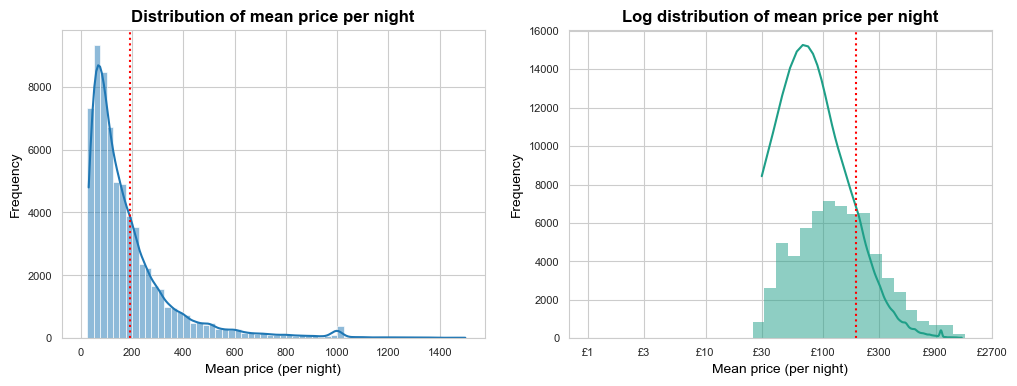

In [18]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
xbinsize = 25
xbins = np.arange(0, listing_clean['price_mean'].max()+xbinsize, xbinsize)
sns.histplot(data=listing_clean, x='price_mean', bins=xbins, kde=True)
plt.axvline(x=listing_clean['price_mean'].mean(), color='r', linestyle=':')
plt.title('Distribution of mean price per night')
plt.xlabel('Mean price (per night)')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
log_binsize = 0.1
xbins = 10 ** np.arange(0, np.log10(listing_clean['price_mean'].max())+log_binsize, log_binsize)
sns.histplot(data=listing_clean, x='price_mean', bins=xbins, color=BASE_COLOR_SUB2, kde=True)
plt.axvline(x=listing_clean['price_mean'].mean(), color='r', linestyle=':')
plt.xscale('log', base=10)
ticks = [1, 3, 10, 30, 100, 300, 900, 2700]
labels = ['£{}'.format(tick) for tick in ticks]
plt.xticks(ticks,labels)

plt.title('Log distribution of mean price per night')
plt.xlabel('Mean price (per night)')
plt.ylabel('Frequency')

plt.show()

#### Let's double check the distribution of independent variables

In [19]:
# we want different approaches for numeric vs categorical features
numerical_features = listing_clean.select_dtypes(include='number').columns.tolist() 
numerical_features.remove('price_mean')
numerical_features.remove('latitude')
numerical_features.remove('longitude')
categorical_features = listing_clean.select_dtypes(exclude='number').columns.tolist() 

In [20]:
listing_clean.head()

host_is_superhost  accommodates  bedrooms  bathrooms  \
listing_id                                                         
157714                  False             3         1        1.5   
13913                   False             1         1        1.0   
15400                   False             2         1        1.0   
306333                  False             5         2        1.0   
159736                  False             2         1        1.0   

            minimum_minimum_nights  calculated_host_listings_count  \
listing_id                                                           
157714                           4                               1   
13913                            1                               2   
15400                            7                               1   
306333                           2                               1   
159736                           4                               4   

            host_years_active  price_mean  private_bathroom  \
listing_id                                                    
157714                     12          70              True   
13913                      14          79             False   
15400                      14         107              True   
306333                     11         198              True   
159736                     12          62             False   

            host_same_location  is_business  availability_90  \
listing_id                                                     
157714                    True        False               67   
13913                     True        False               78   
15400                     True        False                2   
306333                   False        False                4   
159736                   False        False                2   

            neighbourhood_cleansed                property_type  \
listing_id                                                        
157714      hammersmith_and_fulham    private_room_in_townhouse   
13913                    islington  private_room_in_rental_unit   
15400       kensington_and_chelsea           entire_rental_unit   
306333                     hackney           entire_rental_unit   
159736                     lambeth  private_room_in_rental_unit   

                  room_type  review_scores_location  latitude  longitude  
listing_id                                                                
157714         Private room                    4.76  51.48974   -0.22208  
13913          Private room                    4.69  51.56861   -0.11270  
15400       Entire home/apt                    4.93  51.48780   -0.16813  
306333      Entire home/apt                    4.89  51.52748   -0.08172  
159736         Private room                    4.34  51.46788   -0.09993

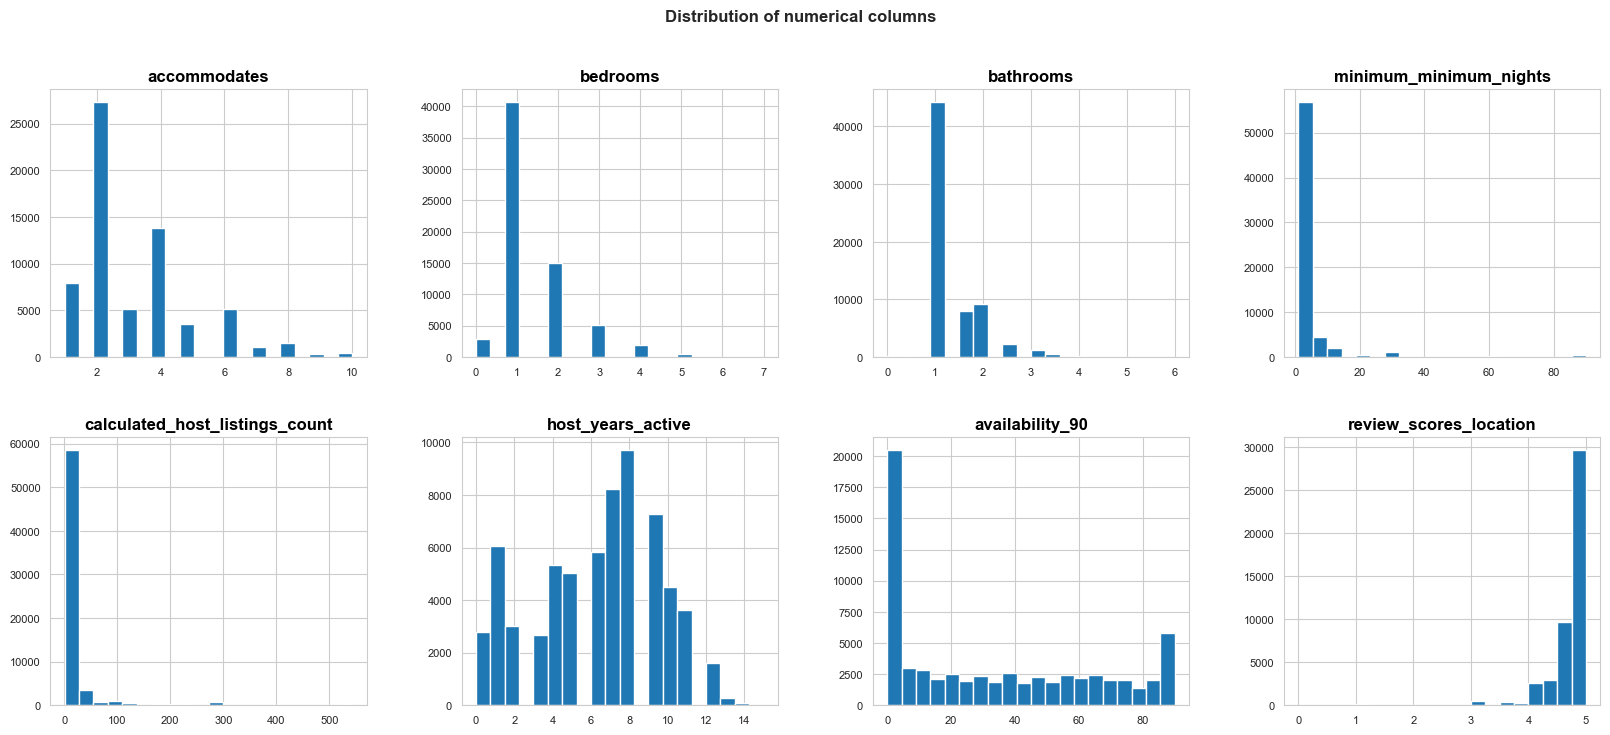

In [21]:
# distribution of numerical columns
pd.plotting.hist_frame(listing_clean, figsize=(20,8), bins=20, layout=(2,4), column=numerical_features, xlabelsize=8, ylabelsize=8)
plt.suptitle('Distribution of numerical columns')
plt.show()

In [22]:
def hist_by_cat(df, col, title='Distribution for', topn=20, base_color=BASE_COLOR,
                   base_highlight=BASE_HIGHLIGHT_INTENSE,
                   lookup=False, df_lookup=None, df_lookup_field=None, figsize=(8,4)):
    """ Count plot - first 3 highest bars are highlighted """

    # calculate top category and order of bar charts
    top = df[col].value_counts(ascending=False)
    top_order = top.index[:topn]
    
    # update topn to max value
    topn = len(top_order) - 1

    # replace index key with key and description
    if lookup:
        top.index = top.index + ':' + df_lookup.loc[top.index][df_lookup_field]

    if topn > 3:    
        clrs = [base_color if i >= 3 else base_highlight for i in np.arange(0, topn + 1, 1)]
    else:
        clrs = [base_color if i >= 3 else base_color for i in np.arange(0, topn + 1, 1)]

    plt.figure(figsize=figsize)
    ax = sns.countplot(data=df, y=col, hue=col, hue_order=top_order, order=top_order, palette=clrs, orient='h', width=0.5, legend=False)

    
    plt.title('{} {}'.format(title, col), weight='bold')
    plt.xlabel('Frequency')
    plt.ylabel(col)
#     ax.legend().set_visible(False)

    # improve xticks and labels      
    ticks, xlabels, binsize = vs.improve_yticks(top.iloc[0])
    plt.xticks(ticks, xlabels, fontsize=8)

#   calculate and print % on the top of each bar
    ticks = ax.get_yticks()
    new_labels = []
    locs, labels = plt.yticks()
    for loc, label in zip(locs, labels):
        count = top.iloc[loc]
        perc = '{:0.1f}%'.format((count / top.sum()) * 100)
        text = top.index[loc]
        new_labels.append(text)
        plt.text(count + (0.2 * binsize), loc, perc, ha='center', va='center', color='black', fontsize=6,
                 weight='ultralight')
    plt.yticks(ticks, new_labels, fontsize=8, weight='ultralight')

    plt.tight_layout()
    plt.show()

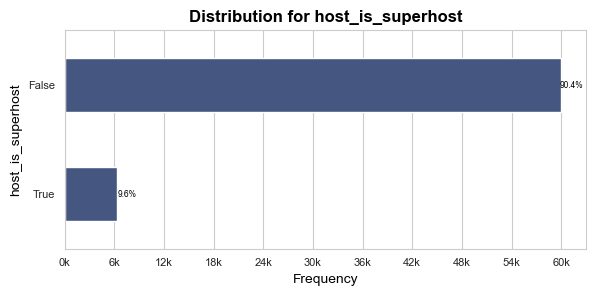

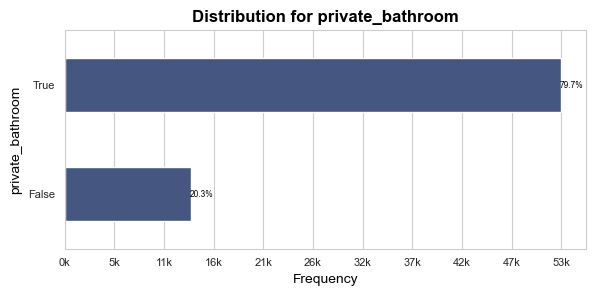

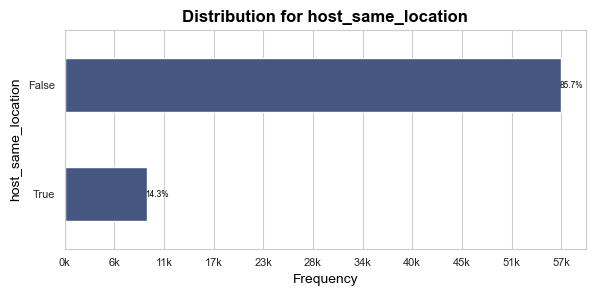

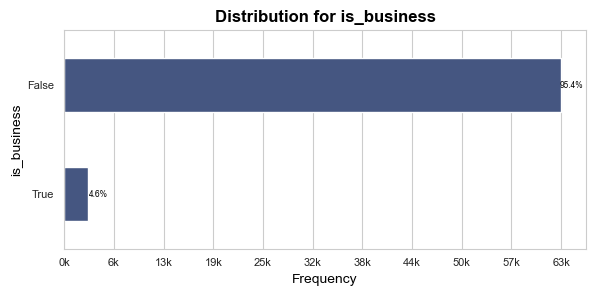

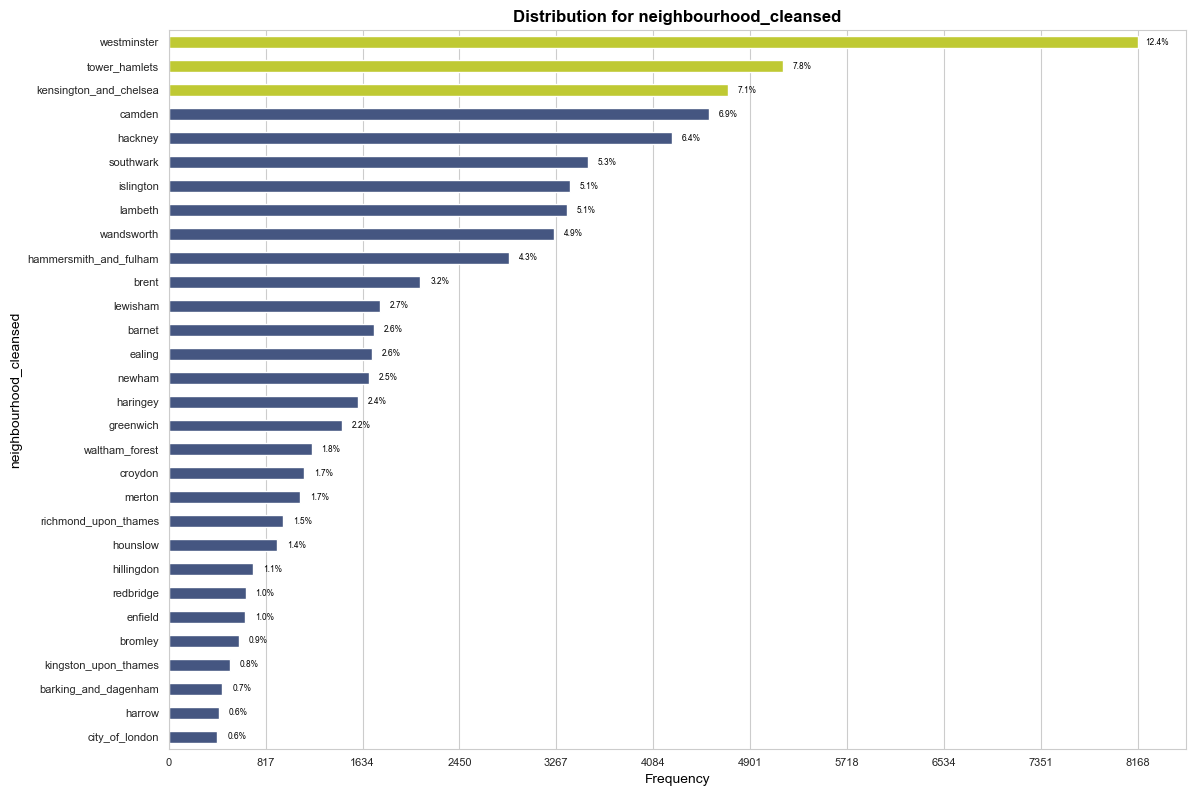

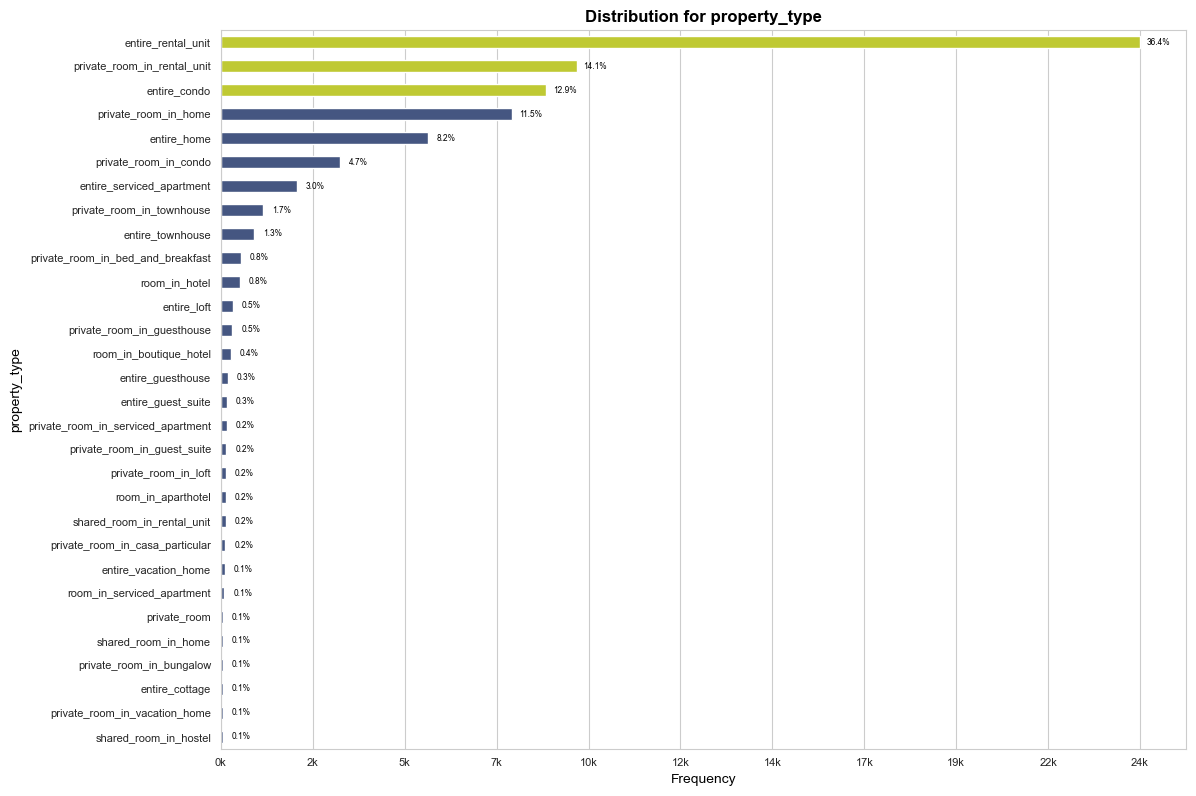

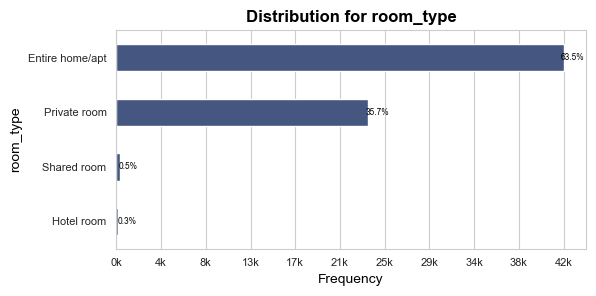

In [23]:
# plot distributions for categorical features
for col in categorical_features:
    if listing_clean[col].nunique() < 5:
        figsize=(6,3)
    else: 
        figsize=(12,8)
    hist_by_cat(df=listing_clean, col=col, topn=30, figsize=figsize)

<a id='Bivariate'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Bivariate Analysis</span>

#### Correlation analysis
- Select features correlated with price
- Make sure independent variables does not have too high correlations

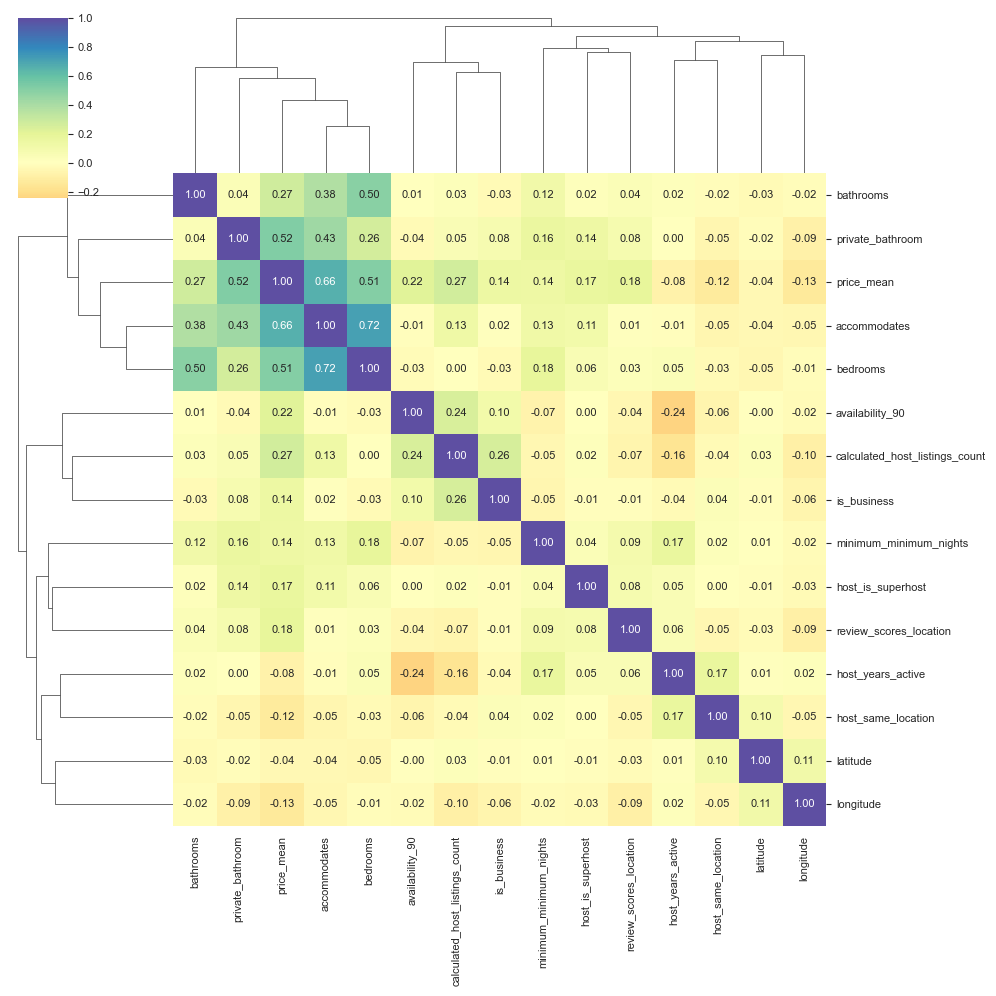

In [24]:
# sns.set(font_scale=1)
sns.clustermap(listing_clean.corr(method='spearman', numeric_only=True, min_periods=1), cmap="Spectral", center=0, annot=True, fmt='.2f', 
               annot_kws={"fontsize":8}, figsize=(10,10))

plt.xticks(fontsize=10)
plt.show()

#### Which kind of relationship features have with price ?

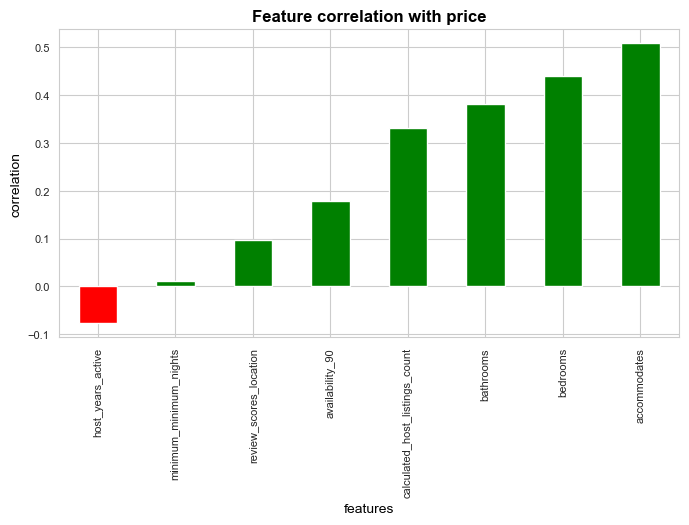

In [25]:
#  Get correlation of features with mean price
corr_matrix = listing_clean[numerical_features].corrwith(listing_clean["price_mean"]).sort_values()

# Plot feature correlations to no_show
corr_matrix.plot(kind='bar', color=np.vectorize({True: 'g', False: 'r'}.get)(corr_matrix > 0))
plt.xticks(rotation='vertical')
plt.ylabel('correlation')
plt.xlabel('features')
plt.title('Feature correlation with price')
plt.show()

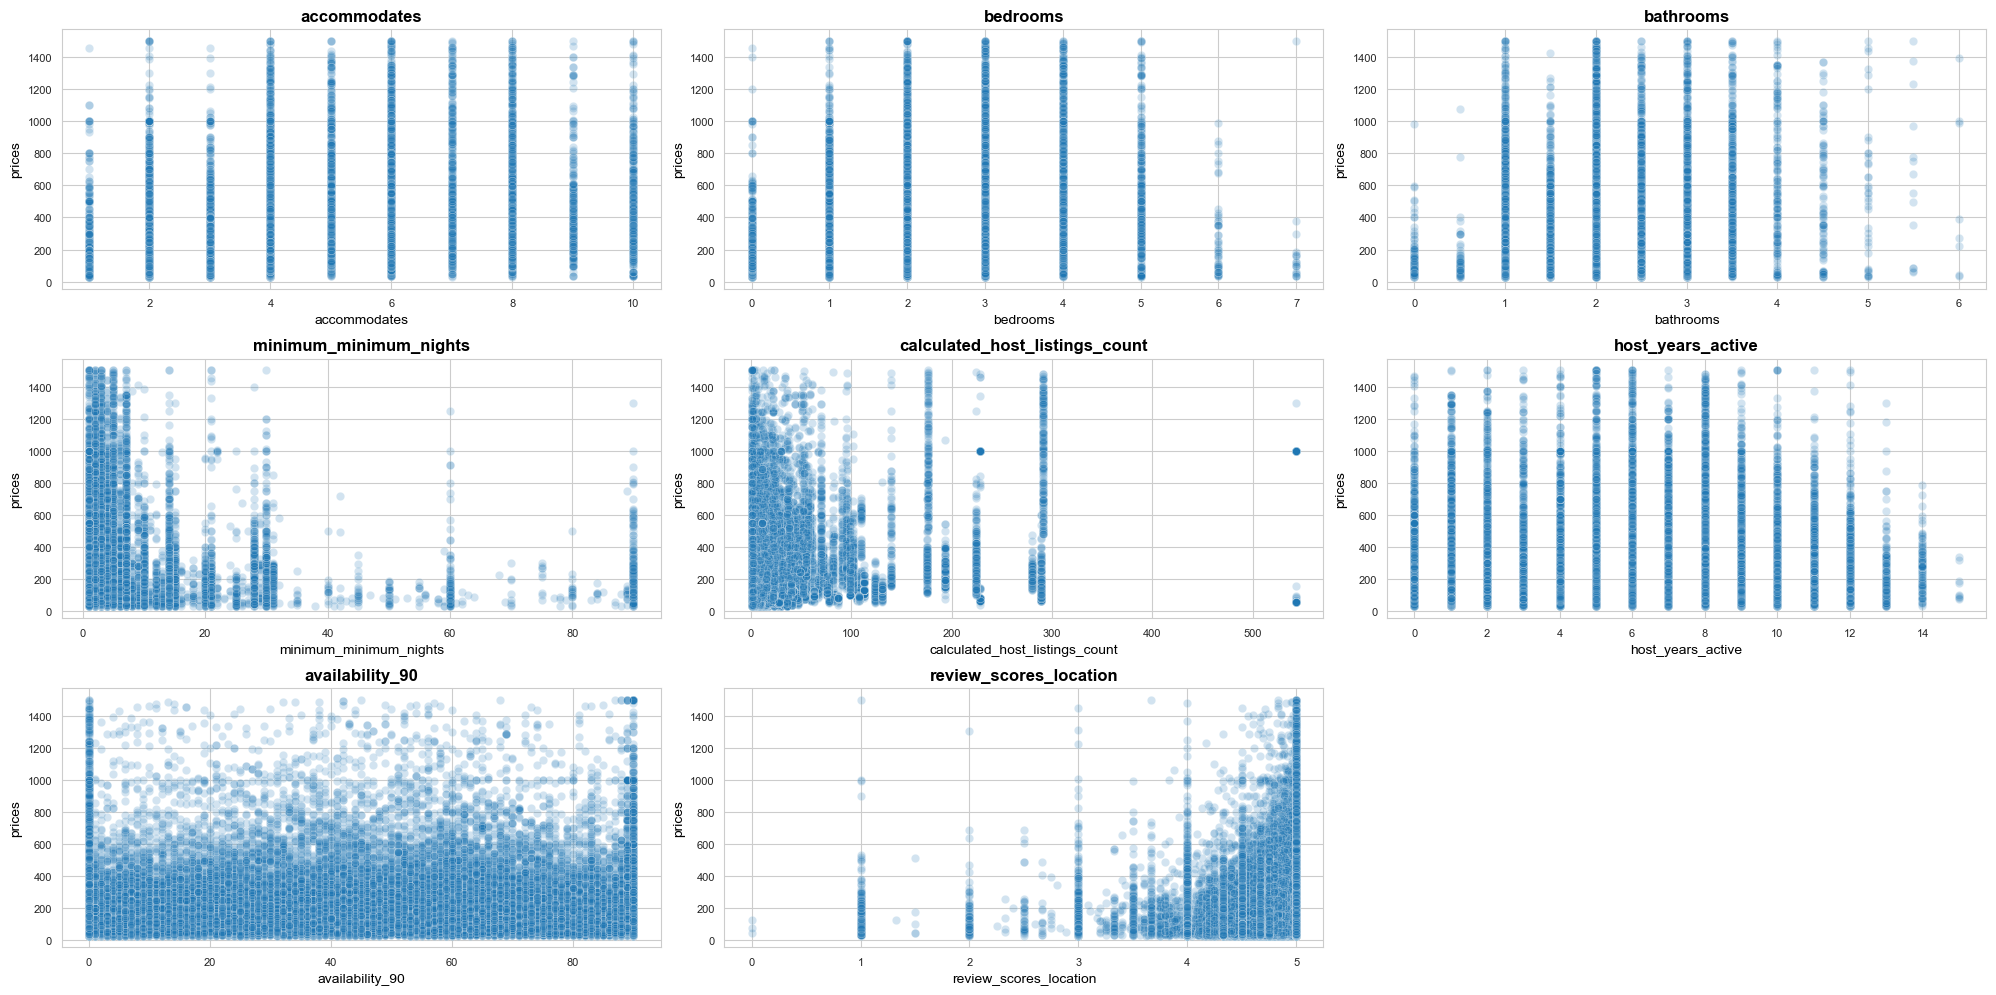

In [26]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x=listing_clean[col], y=listing_clean['price_mean'], alpha=0.2)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')
plt.tight_layout()

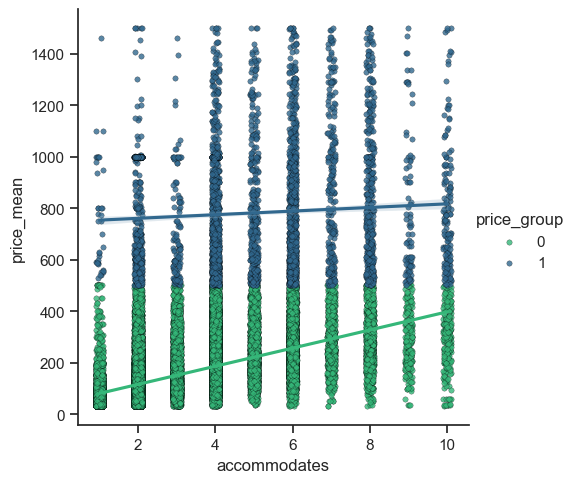

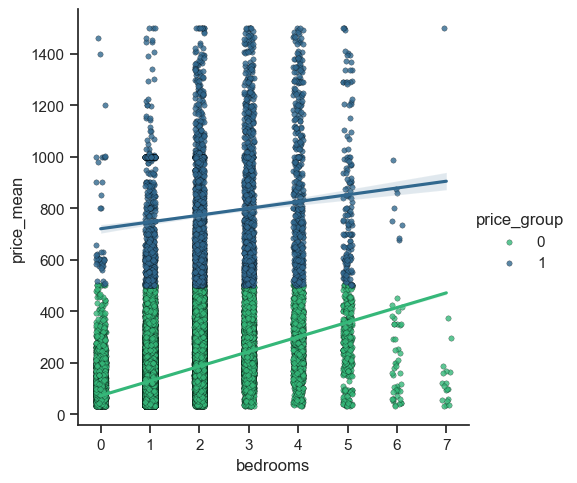

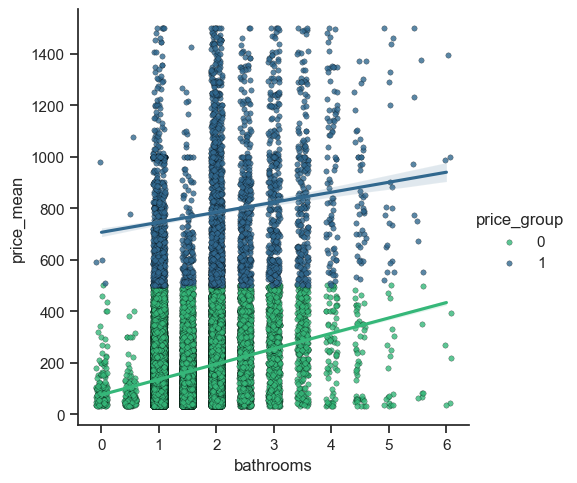

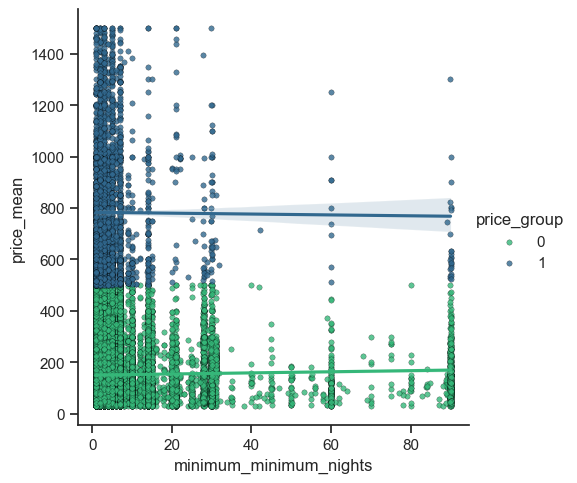

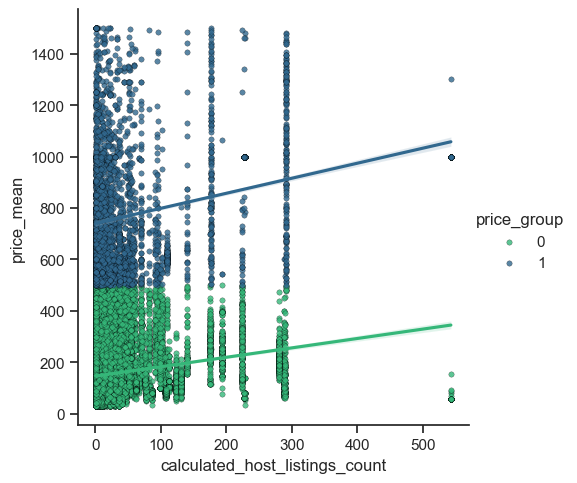

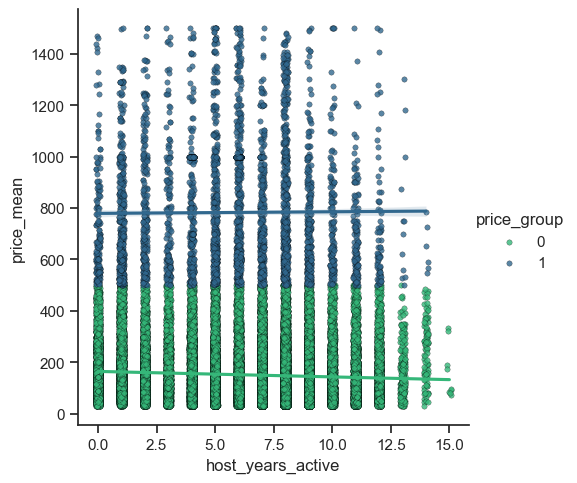

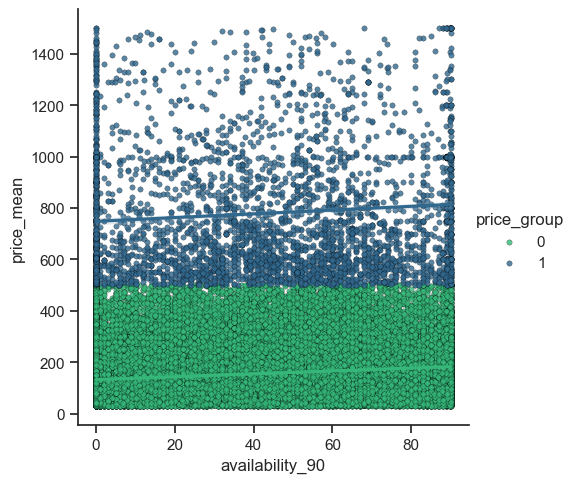

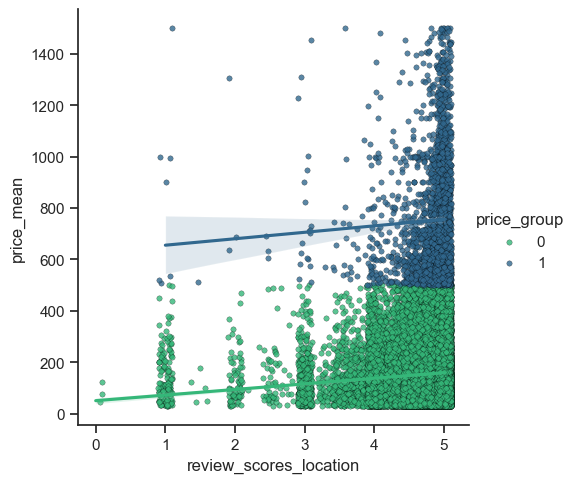

In [27]:
# Correlation analysis

# # take a sample of listings to speed of performance for regplot relationship
# sample = np.random.choice(listing_reduced.shape[0], 20000, replace=False)
# listing_sample = listing_clean.iloc[sample].copy()

# # listing_sample = listing_sample[cols_of_interest].copy()
# listing_sample.dropna(inplace=True)

listing_clean['price_group'] = np.where(listing_clean['price_mean'] <= 500, 0, 1)

sns.set(style='ticks')

x_vars = numerical_features

for col in x_vars:
    sns.lmplot(data=listing_clean, x=col, y='price_mean', hue='price_group', x_jitter=0.1, palette='viridis_r', 
               scatter_kws={'s':15, 'edgecolor':'black', 'linewidths':0.2})

plt.show()

# reset default plot formatting back as PairGrid change the defaults somehow
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

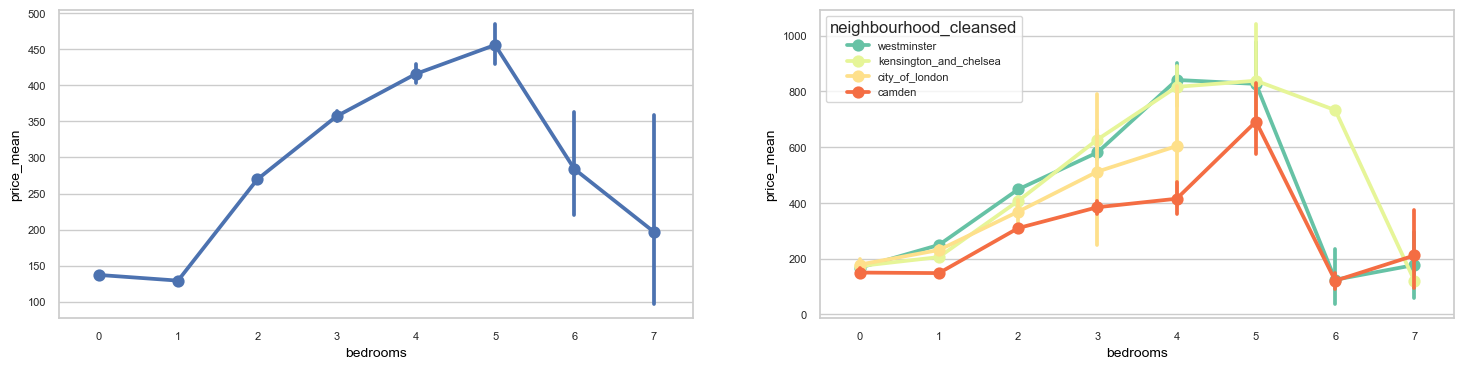

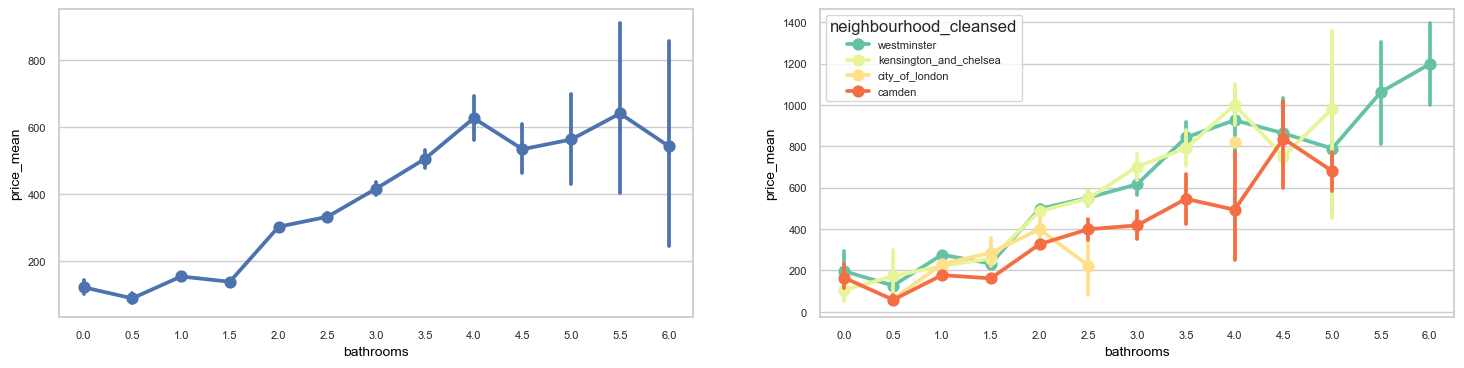

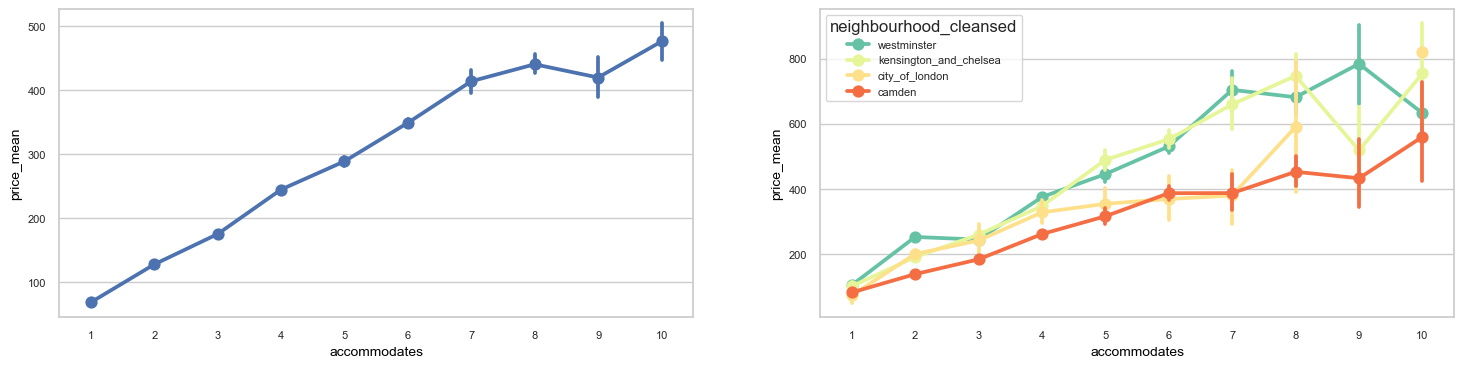

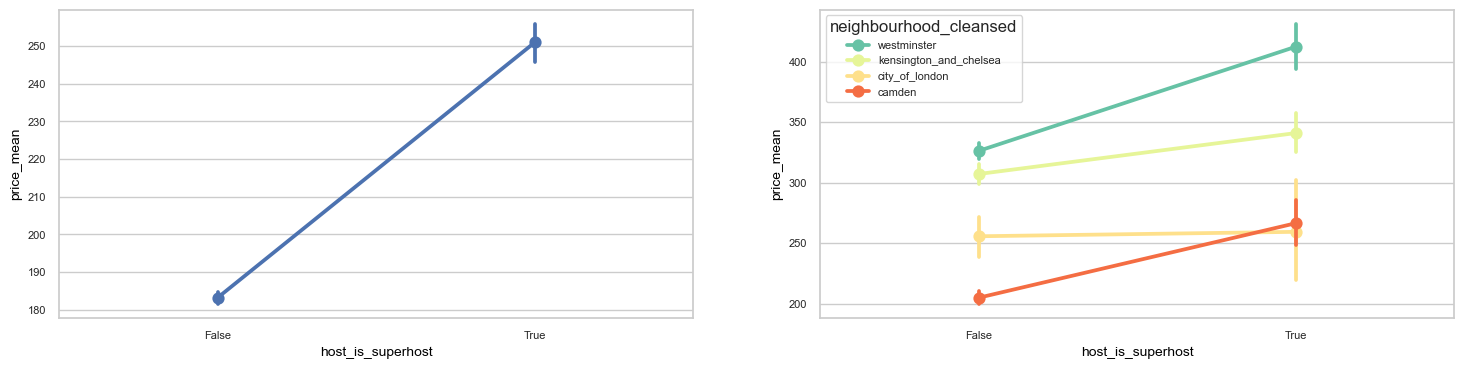

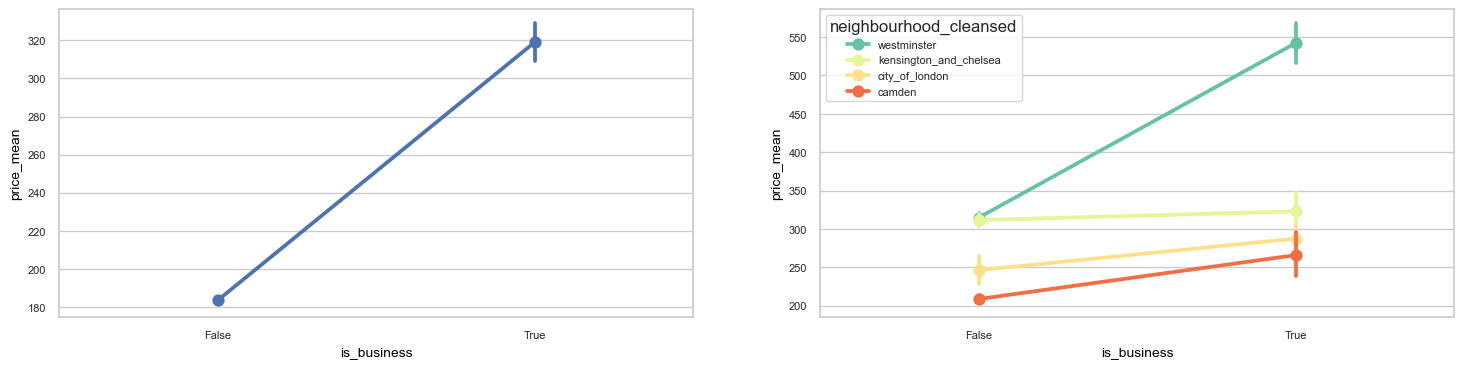

In [28]:
# Interaction with neighbourhood
cat = listing_clean.groupby('neighbourhood_cleansed')['price_mean'].mean().sort_values(ascending=False)
hue_order = list(cat.index)

for col in ['bedrooms', 'bathrooms', 'accommodates', 'host_is_superhost', 'is_business']:          

    plt.figure(figsize=(18,4))
    plt.subplot(1,2,1)
    sns.pointplot(data=listing_clean, x=col, y="price_mean")

    plt.subplot(1,2,2)
    sns.pointplot(data=listing_clean, x=col, y="price_mean", hue='neighbourhood_cleansed', hue_order=hue_order[:4], palette='Spectral_r')
    # plt.legend(bbox_to_anchor=(1,1), loc='upper left')

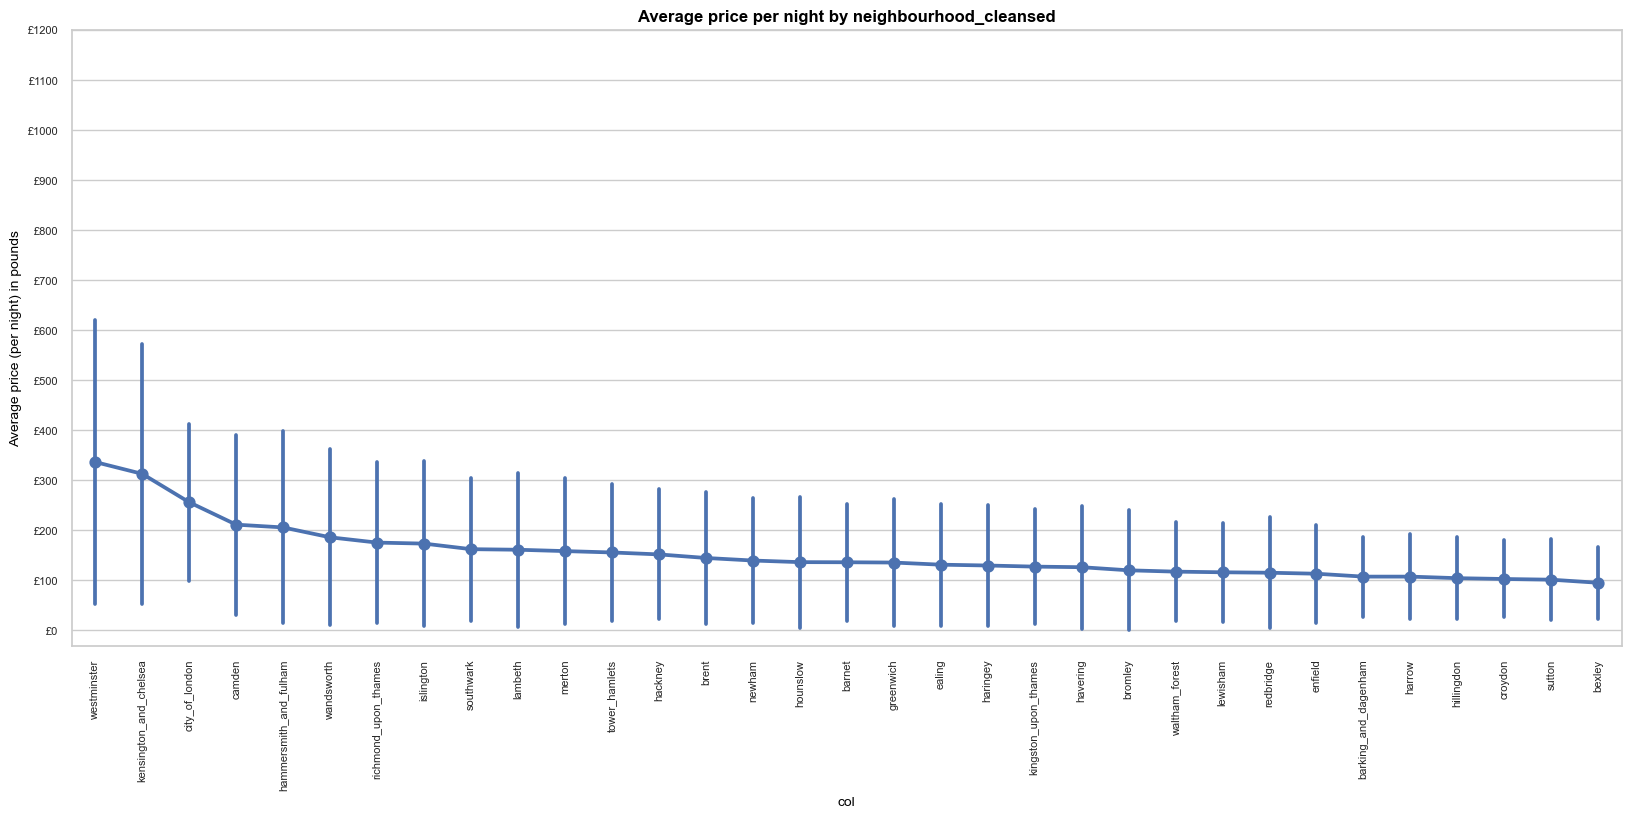

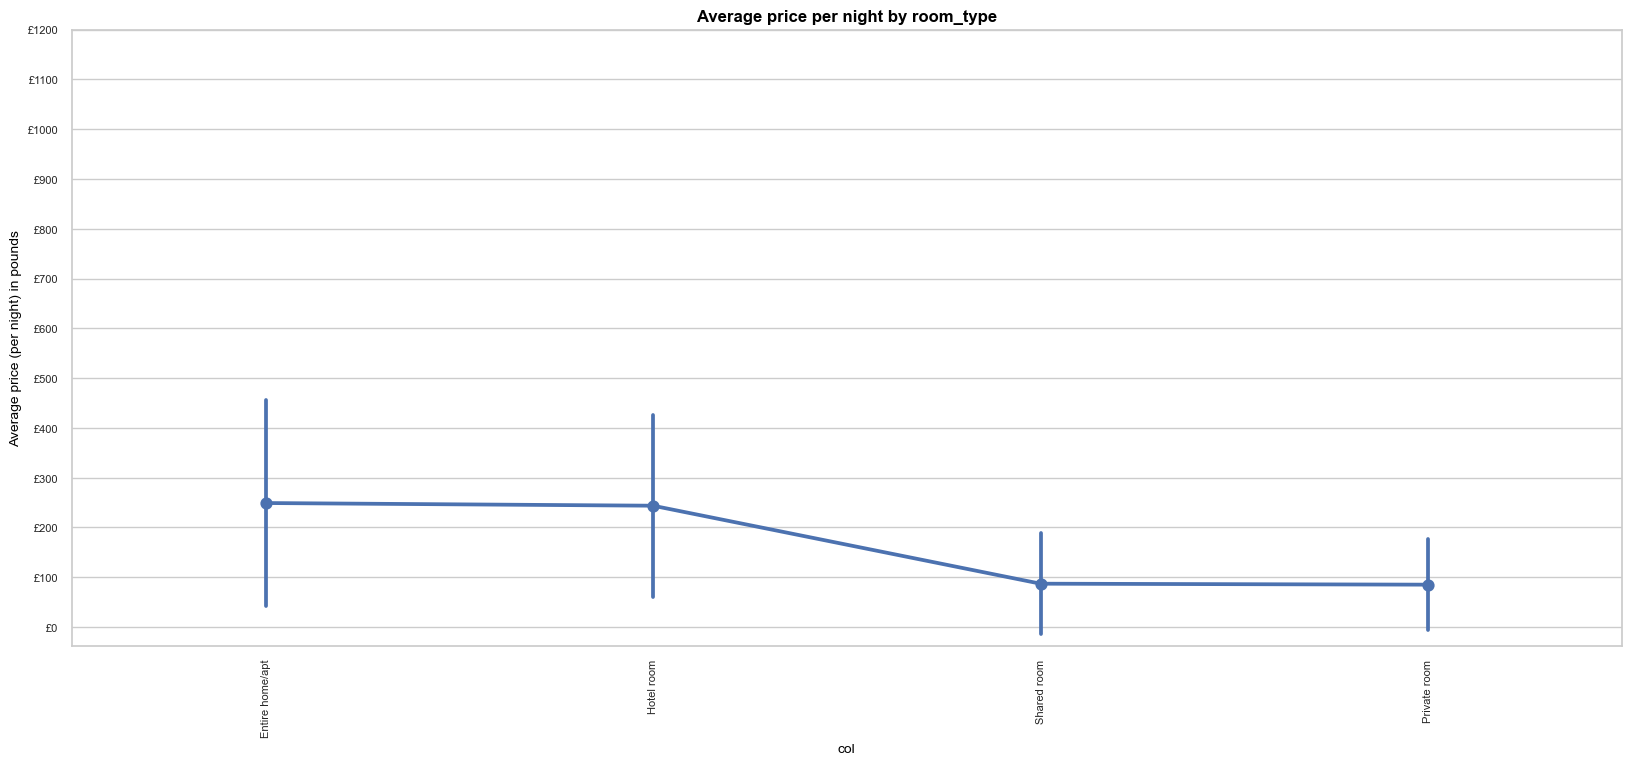

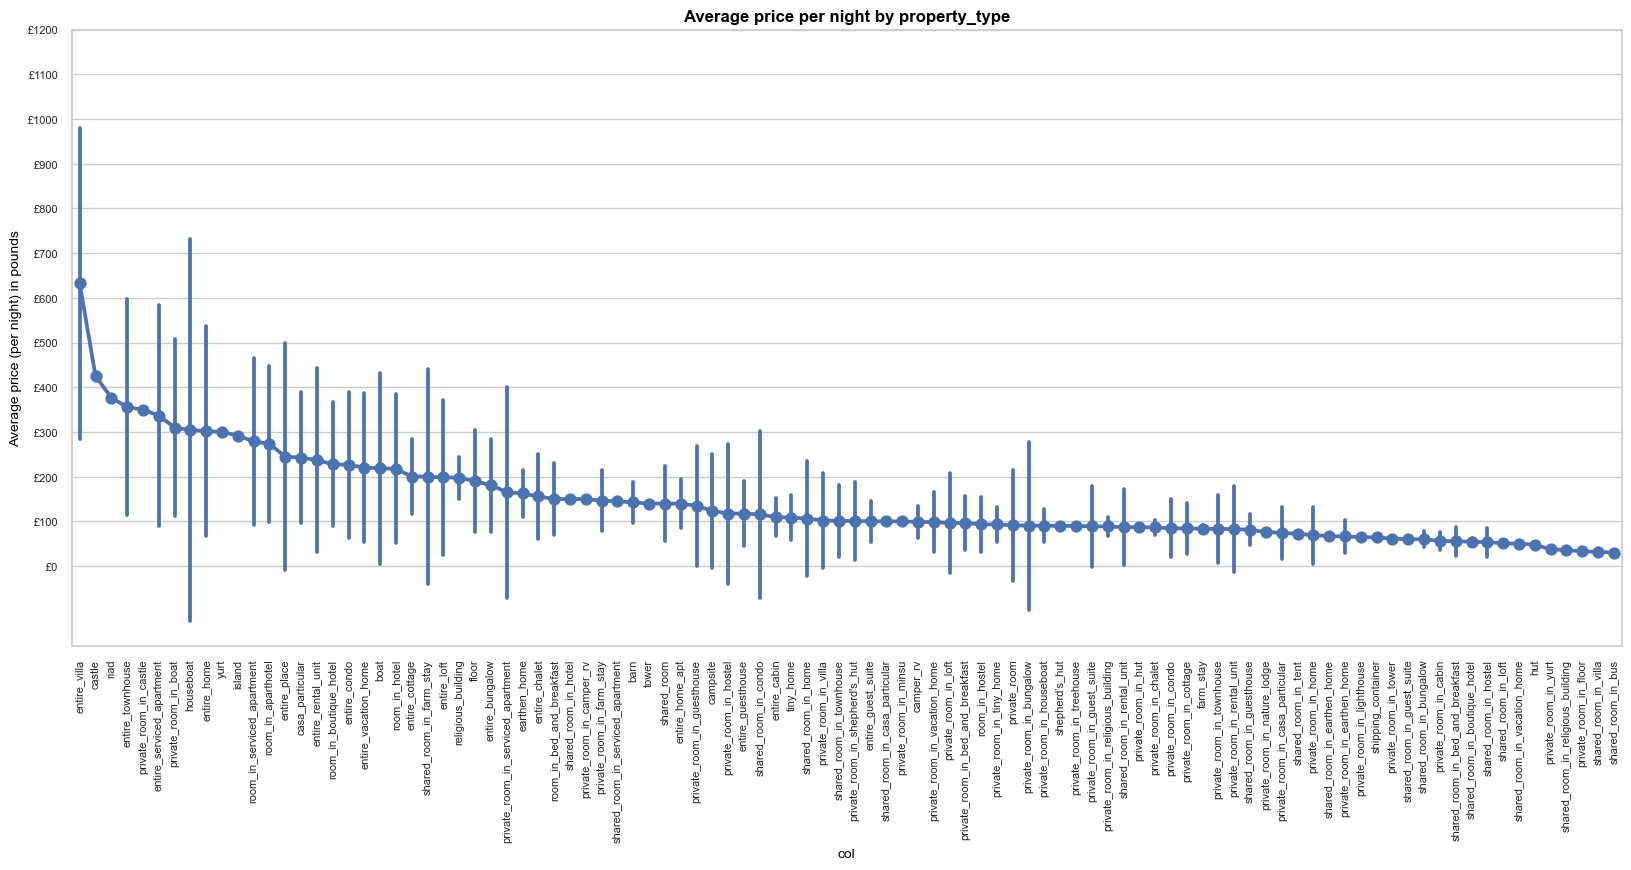

In [29]:
for col in ['neighbourhood_cleansed', 'room_type', 'property_type']:

    try:
        cat = listing_clean.groupby(col)['price_mean'].mean().sort_values(ascending=False)
        order = list(cat.index)

        plt.figure(figsize=(20,8))
        g = sns.pointplot(data=listing_clean, x=col, y='price_mean', errorbar='sd', marker='o', order=order)
        plt.title('Average price per night by {}'.format(col))
        plt.ylabel('Average price (per night) in pounds')
        plt.xlabel('col')

        plt.xticks(rotation=90)
        # plt.ylim(0,1000)
        yticks = np.arange(0, 1300, 100)
        ylabels = ['£{:1.0f}'.format(tick) for tick in yticks] 
        plt.yticks(yticks, ylabels)

        plt.show()
    except:
        pass
        

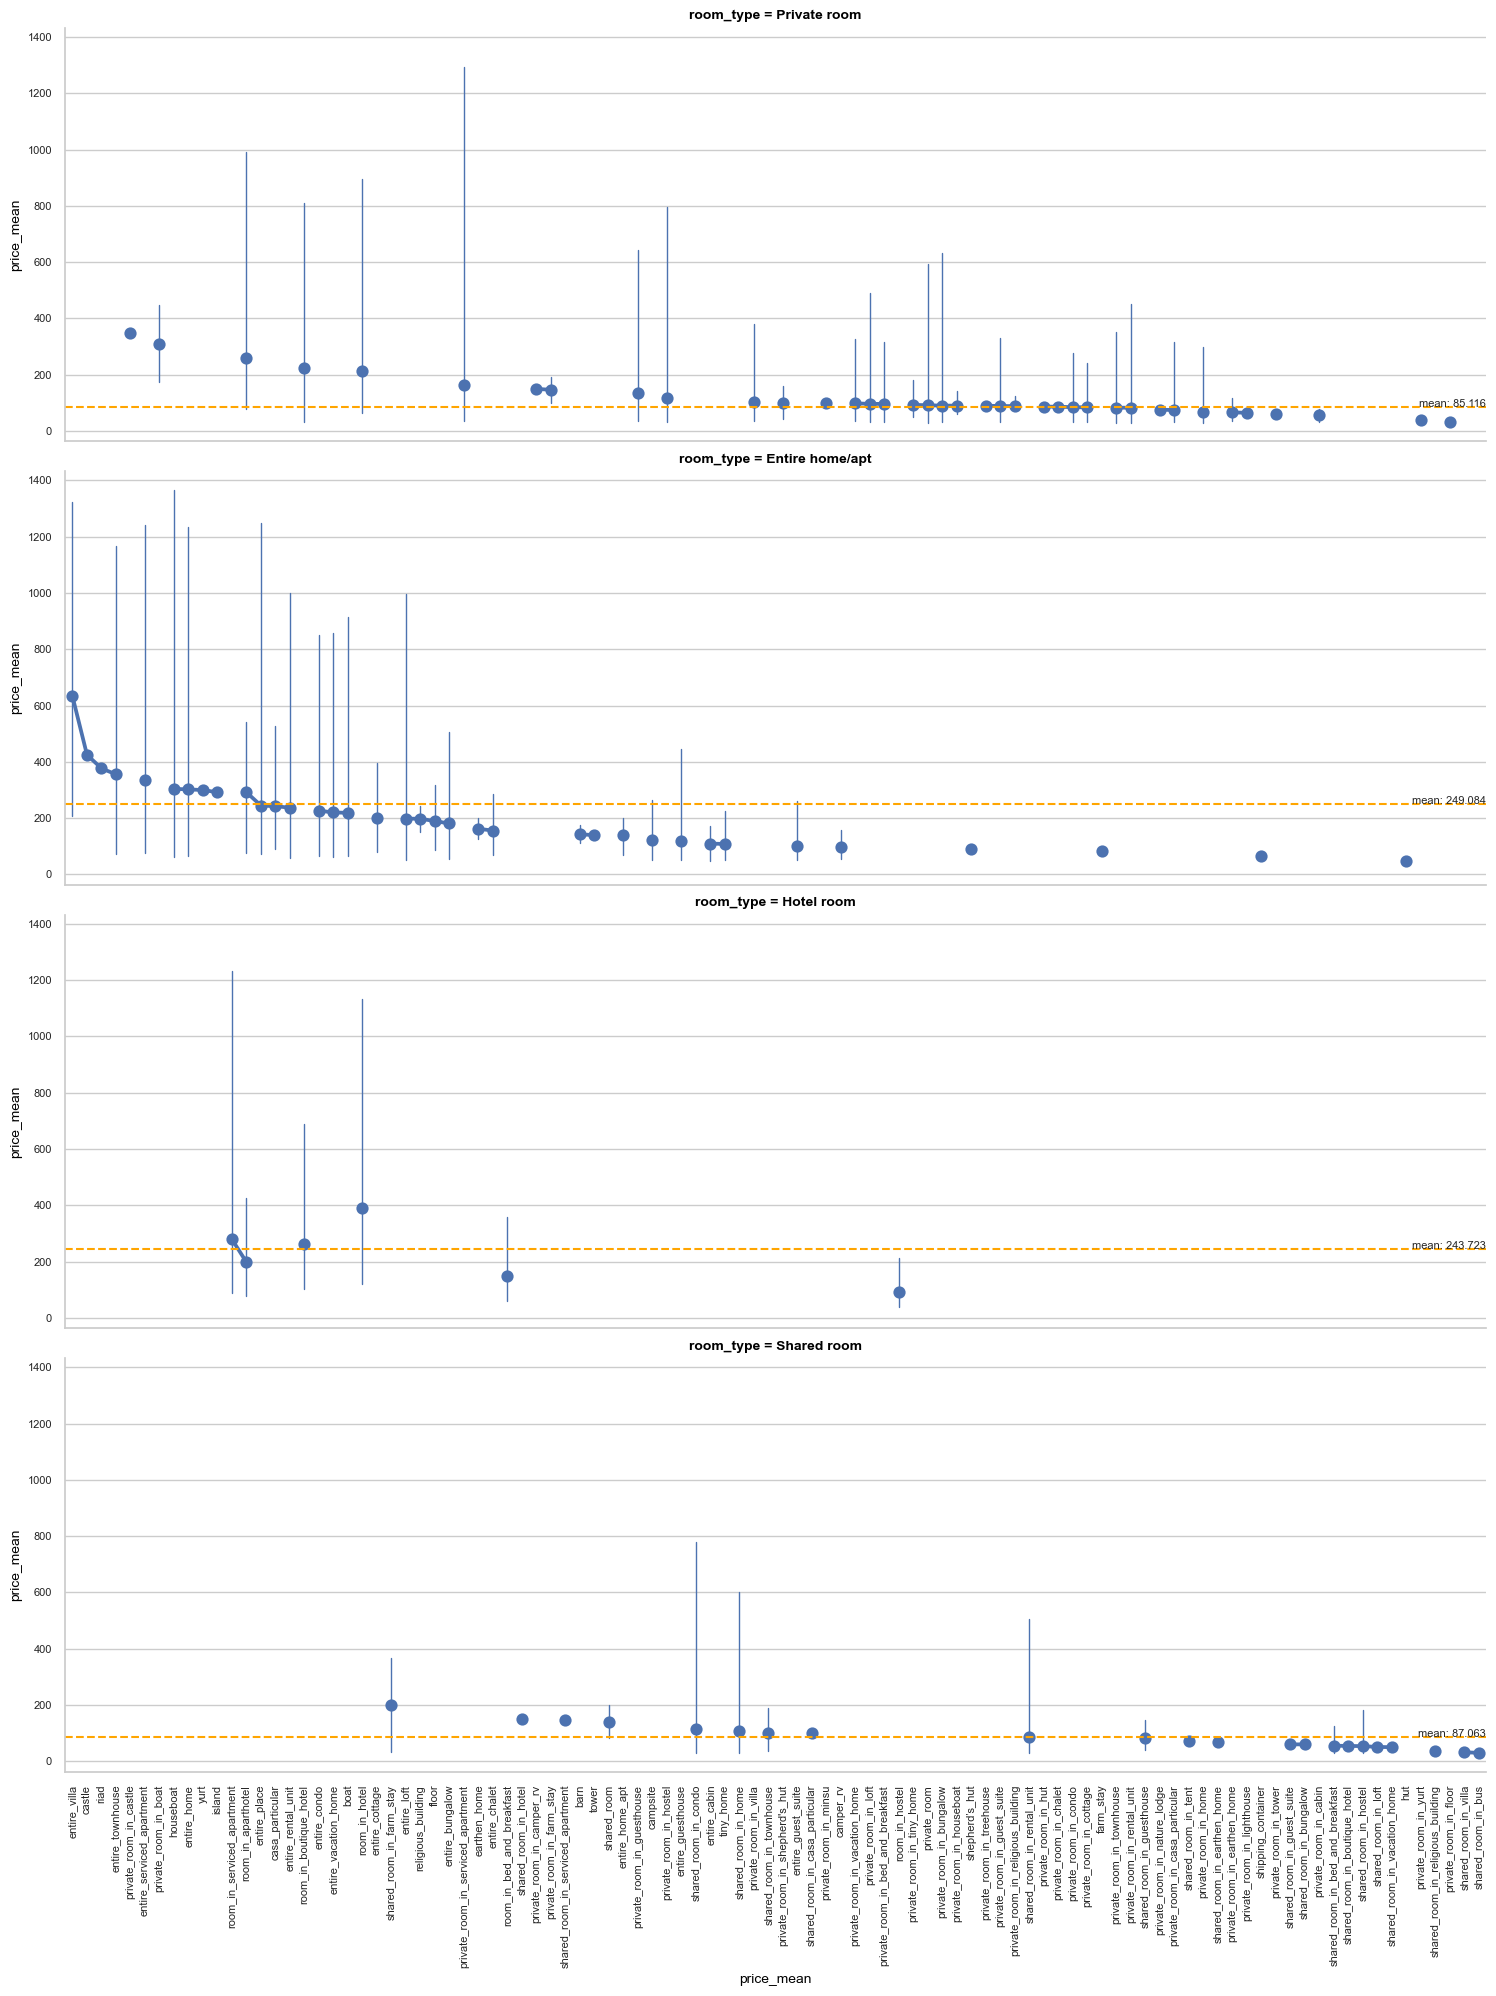

In [30]:
# reset default plot formatting back as PairGrid change the defaults somehow
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

def custom(y, **kwargs):
    ym = y.mean()
    plt.axhline(ym, color="orange", linestyle="dashed")
    plt.annotate(f"mean: {y.mean():.3f}", xy=(1,ym), 
                 xycoords=plt.gca().get_yaxis_transform(), ha="right")

g = sns.FacetGrid(data = listing_clean, row = 'room_type', height=5, aspect=3, sharex=True, sharey=True) 
g.map(sns.pointplot, 'property_type', 'price_mean', order=order, errorbar=('pi', 97.5), seed=88, linestyles=None, 
      err_kws={'linewidth': 1})

# add a mean line to each room type plot
# g = g.map(lambda y, **kw: plt.axhline(y.mean(), color="r", linestyle="dashed", linewidth=2), 'price_mean')

g = g.map(custom, 'price_mean')

# plt.annotate(f"mean: {y.mean():.3f}", xy=(1,ym), 
#                  xycoords=plt.gca().get_yaxis_transform(), ha="right")



# add x labels after each plot
# for ax in g.axes.flatten():
#     ax.tick_params(labelbottom=True, rotation=90, pad=1)

plt.xticks(rotation=90)
plt.tight_layout()

## Let's use clustering to build a better price grouping

In [31]:
# Cluster prices - lets build better price groups
X = listing_clean[['latitude', 'longitude', 'price_mean']].copy(deep=True)
X.head()

latitude  longitude  price_mean
listing_id                                 
157714      51.48974   -0.22208          70
13913       51.56861   -0.11270          79
15400       51.48780   -0.16813         107
306333      51.52748   -0.08172         198
159736      51.46788   -0.09993          62

In [32]:
gmm = GaussianMixture(n_components=9, random_state=random_state, covariance_type='spherical', init_params='k-means++')
X['price_group'] = gmm.fit_predict(X)
X.head()

latitude  longitude  price_mean  price_group
listing_id                                              
157714      51.48974   -0.22208          70            5
13913       51.56861   -0.11270          79            5
15400       51.48780   -0.16813         107            5
306333      51.52748   -0.08172         198            6
159736      51.46788   -0.09993          62            2

In [33]:
tmp = X.groupby('price_group', observed=False).agg(min=('price_mean', 'min'), max=('price_mean', 'max')).sort_values(by='min')
tmp['rank'] = tmp['min'].rank(method='max').astype('int')
tmp

min   max  rank
price_group                  
2              30    66     1
5              67   110     2
0             111   164     3
6             165   222     4
4             223   306     5
7             307   420     6
1             421   632     7
8             633  1078     8
3            1080  1500     9

In [37]:
# sort price cluster by price
mymap = pd.Series(tmp['rank'].values,index=tmp.index).to_dict()
mymap

{2: 1, 5: 2, 0: 3, 6: 4, 4: 5, 7: 6, 1: 7, 8: 8, 3: 9}

In [38]:
X['ranked_price_group'] = X['price_group'].map(mymap)
X.head()

latitude  longitude  price_mean  price_group  ranked_price_group
listing_id                                                                  
157714      51.48974   -0.22208          70            5                   2
13913       51.56861   -0.11270          79            5                   2
15400       51.48780   -0.16813         107            5                   2
306333      51.52748   -0.08172         198            6                   4
159736      51.46788   -0.09993          62            2                   1

In [85]:
listing_clean['price_group'] = X['ranked_price_group']

###### Visualize the clusters

In [120]:
cols = ['latitude', 'longitude', 'price_group']
listings_geo = listing_clean[cols].copy(deep=True)
listings_geo.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)
listings_geo.head()

latitude  longitude  price_group
listing_id                                  
157714      51.48974   -0.22208            2
13913       51.56861   -0.11270            2
15400       51.48780   -0.16813            2
306333      51.52748   -0.08172            4
159736      51.46788   -0.09993            1

In [121]:
neighbourhood.head()

neighbourhood neighbourhood_group  \
0  kingston_upon_thames                None   
1               croydon                None   
2               bromley                None   
3              hounslow                None   
4                ealing                None   

                                            geometry  price_mean  
0  MULTIPOLYGON (((-0.330679000000000 51.32901100...  127.436293  
1  MULTIPOLYGON (((-0.064021000000000 51.31863800...  102.708042  
2  MULTIPOLYGON (((0.012131000000000 51.299599000...  120.061017  
3  MULTIPOLYGON (((-0.244562000000000 51.48870200...  136.378705  
4  MULTIPOLYGON (((-0.411833000000000 51.53408400...  131.304729

In [122]:
# make geometry field
listings_geo['geometry'] = listings_geo.apply(lambda x: Point((x.longitude, x.latitude)), axis=1)
type(listings_geo)

pandas.core.frame.DataFrame

In [123]:
listings_geo = gpd.GeoDataFrame(listings_geo, crs=crs_4326, geometry=listings_geo.geometry)
listings_geo.head()

latitude  longitude  price_group  \
listing_id                                     
157714      51.48974   -0.22208            2   
13913       51.56861   -0.11270            2   
15400       51.48780   -0.16813            2   
306333      51.52748   -0.08172            4   
159736      51.46788   -0.09993            1   

                                                 geometry  
listing_id                                                 
157714      POINT (-0.222080000000000 51.489739999999998)  
13913       POINT (-0.112700000000000 51.568610000000000)  
15400       POINT (-0.168130000000000 51.487800000000000)  
306333      POINT (-0.081720000000000 51.527479999999997)  
159736      POINT (-0.099930000000000 51.467880000000001)

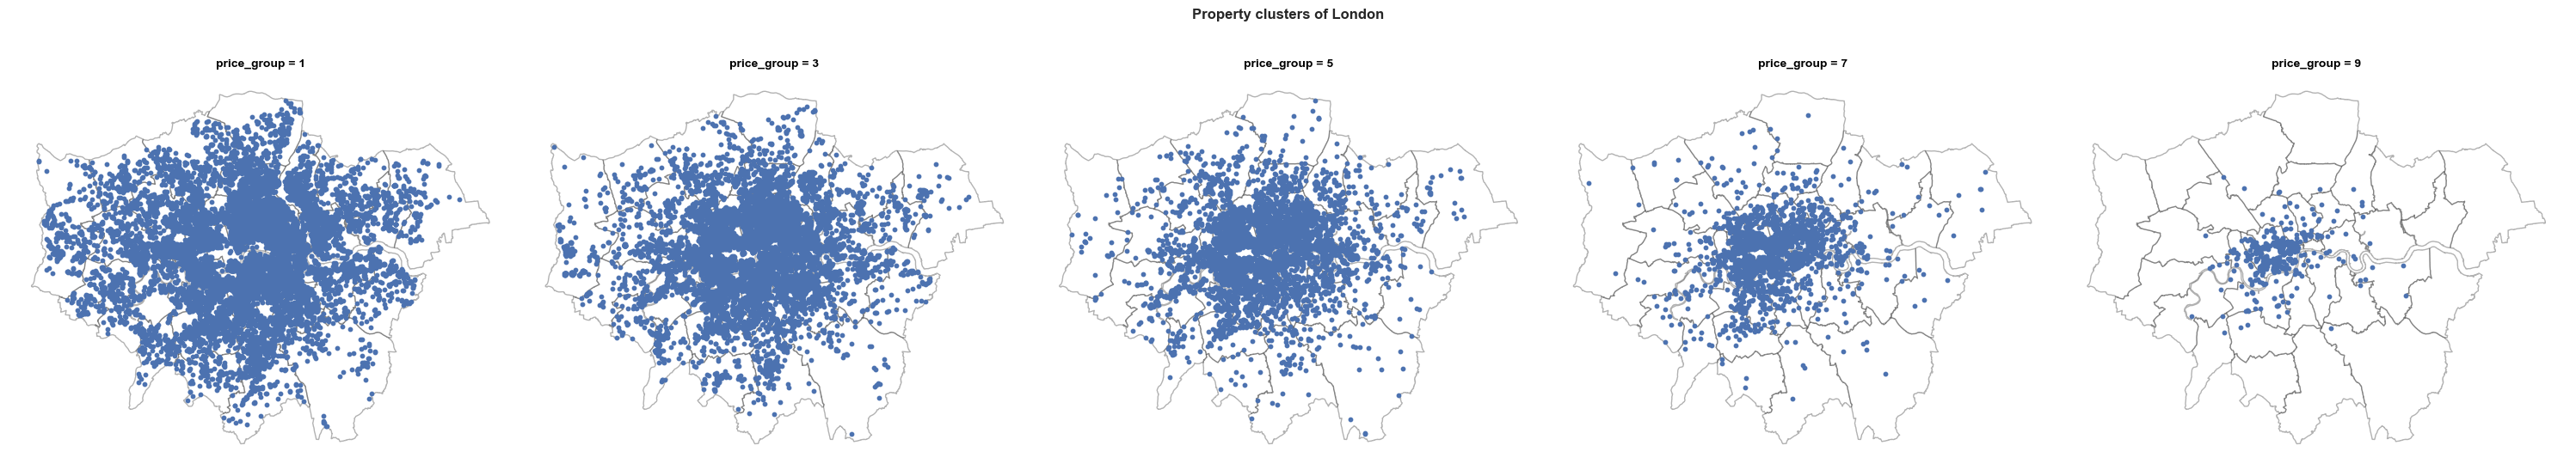

In [127]:
def plot_map(data, color):
    base = data.plot(ax=plt.gca(), zorder=2, marker='o', markersize=10) 
    neighbourhood.plot(color='white', edgecolor='black', zorder=1, alpha=0.3, ax=base)
    base.set_axis_off();
    
g = sns.FacetGrid(data=listings_geo, col = 'price_group', col_order=list(np.arange(1, len(tmp)+1, 2)), height=6, aspect=1)
g.map_dataframe(plot_map)
plt.xlabel('Latitude')


plt.suptitle('Property clusters of London')
plt.tight_layout()

In [ ]:
# g = sns.FacetGrid(data=listings_geo, col = 'price_group', col_order=list(np.arange(1, len(tmp)+1, 2)), height=6, aspect=1)
# base = g.map(neighbourhood.plot, color='white', edgecolor='black', zorder=2, alpha=0.3)
# g.map(sns.scatterplot, 'longitude', 'latitude', ax=base, zorder=1) 
# # g.map(sns.kdeplot, 'longitude', 'latitude')
# plt.suptitle('Property clusters of London')
# plt.tight_layout()

**Observation**:
- slopes do not match, we will need an interaction term

In [ ]:
# cleaning data / preprocessing step before we split out data into train/test

X_property = listing_clean[['room_type', 'property_type', 'latitude', 'longitude', 'price_mean']].copy(deep=True)

onehot = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int'))])

onehot_preprocessor = ColumnTransformer(transformers=[
    ('category', onehot, ['property_type', 'room_type']),
], 
        verbose_feature_names_out=False, 
        remainder = 'passthrough'                                                         
)

_ = onehot_preprocessor.fit(X_property).set_output(transform="pandas") 

X_property_transformed = onehot_preprocessor.transform(X_property)
X_property_transformed.head()

In [ ]:
# clear the garbage to free memory
gc.collect()

In [ ]:
# # Cluster properties
# X_property = listing_clean[['room_type', 'property_type', 'latitude', 'longitude', 'price_mean']].copy(deep=True)
# le = preprocessing.LabelEncoder()
# X_property['property_label'] = le.fit_transform(X_property['property_type'])
# X_property_transformed = X_property.drop('property_type', axis=1)
# X_property.head()

In [ ]:
gmm = GaussianMixture(n_components=20, random_state=random_state, covariance_type='spherical', init_params='k-means++')
X_property_transformed['cluster'] = gmm.fit_predict(X_property_transformed)
X_property_transformed.head()

In [ ]:
test = X_property_transformed.groupby('cluster').agg(min=('price_mean', 'min'), max=('price_mean', 'max')).sort_values(by='min')
test['rank'] = test['min'].rank(method='max').astype('int')
test

In [ ]:
# sort new price_group by price
mymap = pd.Series(test['rank'].values,index=test.index).to_dict()
mymap

In [ ]:
X_property_transformed['property_cluster'] = X_property_transformed['cluster'].map(mymap)
X_property_transformed.head()

In [ ]:
listing_clean['property_cluster'] = X_property_transformed['property_cluster']

In [ ]:
listing_clean.head()

# Model pre-processing

In [ ]:
try:
    listing_clean = listing_clean.drop(['latitude', 'longitude', 'property_type'], axis=1)
except:
    pass

In [ ]:
listing_clean.head()

In [ ]:
def func(x):
    return np.log10(x)

def inverse_func(x):
    return sp.special.exp10(x)

In [ ]:
# split the data into train and test
y = listing_clean['price_mean'].copy()
X = listing_clean.drop('price_mean', axis=1)

In [ ]:
# we want different approaches for numeric vs categorical features
numerical_features = X.select_dtypes(include='number').columns.tolist()   
print('Numerical features {}'.format(numerical_features))
categorical_features = X.select_dtypes(exclude='number').columns.tolist() 
print('Categorical features {}'.format(categorical_features)) 

In [ ]:
# cleaning data / preprocessing step before we split out data into train/test
onehot_pipe = Pipeline(steps=[
    ('one-hot', OneHotEncoder(dtype='int', 
                              drop="if_binary", 
                              handle_unknown='infrequent_if_exist', 
                              sparse_output=False, 
                              min_frequency=25))   
])

onehot_preprocessor = ColumnTransformer(transformers=[
    ('category', onehot_pipe, categorical_features),
], 
        verbose_feature_names_out=False, 
        remainder = 'passthrough'                                                         
)

_ = onehot_preprocessor.fit(X).set_output(transform="pandas") 

In [ ]:
X_transformed = onehot_preprocessor.transform(X)
X_transformed.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=10, 
                                                    stratify=X['is_business'],
                                                   )
      

In [ ]:
# cleaning data / preprocessing step

# Iterative imputer: restrict the values to be predicted to a min / max range
# minimum_before_numeric = list(df.loc[:, numerical_features].min(axis=0))
# maximum_after_numeric = list(df.loc[:, numerical_features].max(axis=0))
#     print(minimum_before_numeric)
#     print(maximum_after_numeric)


numerical_preprocessor = Pipeline(steps=[
#         ('impute', IterativeImputer(initial_strategy='median', max_iter=3, skip_complete=True, 
#                                     verbose=0, n_nearest_features=None, imputation_order='descending', 
#                                     random_state=random_state)),  
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])


# categorical_preprocessor = Pipeline(steps=[
#     ('one-hot', OneHotEncoder(dtype='int', 
#                               drop="if_binary", 
#                               handle_unknown='infrequent_if_exist', 
#                               sparse_output=False, 
#                               min_frequency=25)),       

# ])

preprocessor = ColumnTransformer(transformers=[

    ('number', numerical_preprocessor, numerical_features),
    # ('category', categorical_preprocessor, categorical_features),


], 
        verbose_feature_names_out=False, 
        remainder = 'passthrough'                                                         
#         remainder='drop',
)

In [ ]:
# test = listing_clean.groupby('property_type').agg(count=('property_type','count'),
#                                                   price=('price_mean', 'mean'))
# test = test.sort_values(by='count', ascending=False)
# test

In [ ]:
# listing_clean.drop('price_group', axis=1, inplace=True)
# listing_transformed = make_preprocessor(listing_clean.copy(deep=True))
# listing_transformed.shape

Mutual Information (MI) is a way to how every feature interact with the target variable in this case 'price'. Here to interact means how a particular feature changes the target variable. The higher the score, the stronger the interaction.
Note: Mutual Information only works with numerrical data

In [ ]:
# from sklearn.feature_selection import mutual_info_regression

# def get_mi_score(X, y):
#     mi = mutual_info_regression(X, y, random_state=10)
#     mi = pd.Series(mi, index=X.columns).sort_values(ascending=False)
#     return mi


# # display Mutual Information scores of the features
# mi_score = get_mi_score(X, y)


# plt.figure(figsize=(6, 20))
# ax = sns.barplot(y=mi_score.index[1:], x=mi_score[1:])
# ax.set_title('MI scores', fontdict={'fontsize': 16})
# plt.show()

### Test for multicollinearity

In [ ]:
#gather features
# vip_features = " + ".join(X_train.columns)
# vip_features

In [ ]:
# merge X and y as required by statsmodels
# vip_df = X_train.merge(y_train, left_index=True, right_index=True)

In [ ]:
# sm_y, sm_X = dmatrices('price_mean ~' + vip_features, vip_df, return_type='dataframe')
# vif = pd.DataFrame()
# vif['VIF Factor'] = [variance_inflation_factor(sm_X.values, i) for i in range(sm_X.shape[1])]
# vif['features'] = sm_X.columns
# vif

# Modelling Step 1 - Setting a baseline with small Ridge

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import cross_validate

# linear_regression = LinearRegression()

# poly_features = PolynomialFeatures(
#     degree=2, include_bias=False, interaction_only=True
# )
# linear_regression_interactions = make_pipeline(poly_features, 
#                                                linear_regression
#                                               ).set_output(transform="pandas")

# # solution
# cv_results = cross_validate(
#     linear_regression_interactions,
#     X_train,
#     y_train,
#     cv=10,
#     scoring="neg_root_mean_squared_error",
#     n_jobs=2,
# )

# print(
#     "Mean absolute error on testing set with interactions: "
#     f"{-cv_results['test_score'].mean():.3f} ± "
#     f"{cv_results['test_score'].std():.3f} g"
# )

In [ ]:
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier, VotingRegressor

# alphas = (0.001, 0.01, 0.1, 0.5, 0.9, 1.1, 1.5, 2, 2.5, 5, 10, 100)

# # Linear model 
# lr = LinearRegression()

# # ridge
# ridge = Ridge(alpha=1e-10)

# # ridge cv
# ridge_cv = RidgeCV(alphas)

# # Ensemble
# lr_xgb_rf = VotingRegressor(estimators=[('lr', lr), ('ridge', ridge), ('ridge_cv', ridge_cv)])

In [ ]:
# base modelling

# Lets evaluate the performance of Ridge estimator with a small alpha, with and without target log transformation

base_model = Pipeline(
    [
        ("preprocess", preprocessor),
        ('selector', VarianceThreshold(0)),
        ("base", Ridge(alpha=1e-10)),         
#         ("base_transformed", TransformedTargetRegressor(regressor=Ridge(alpha=1e-10), 
#                                                         func=func,
#                                                         inverse_func=inverse_func)),                     
    ]
)

# base_model.set_output(transform="pandas")

base_model_with_log_target = Pipeline(
    [
        ("preprocess", preprocessor),
        ('selector', VarianceThreshold(0)),        
        ("base_transformed", TransformedTargetRegressor(regressor=Ridge(alpha=1e-10), 
                                                        func=func,
                                                        inverse_func=inverse_func)),                     
    ]
)

In [ ]:
_ = base_model.fit(X_train, y_train).set_output(transform="pandas")

In [ ]:
_ = base_model_with_log_target.fit(X_train, y_train).set_output(transform="pandas")

# Evaluation

In [ ]:
def goodness_of_fit(y, y_hat, show=False):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """

    #Calculate the performance scores
    r2 = r2_score(y, y_hat)
    mse = mean_squared_error(y, y_hat) 
    mae = mean_absolute_error(y, y_hat) 
    maeEd = median_absolute_error(y, y_hat) 

    if show:
        print("R-squared: {:.2f}".format(r2))
        print("Mean Squared Error (MSE): {:.2f}".format(mse))
        print("Median Absolute Error: {:.2f}".format(maeEd))    
        print("Mean Absolute Error: {:.2f}".format(mae))  
        

    return {
        "R-squared": f"{r2_score(y, y_hat):.3f}",
        "Median Absolute Error": f"{median_absolute_error(y, y_hat):.3f}",
        "Mean Absolute Error": f"{mean_absolute_error(y, y_hat):.3f}",
        "Mean Squared Error": f"{mean_squared_error(y, y_hat):.3f}",
    }        

In [ ]:
# predict
y_train_preds = base_model.predict(X_train)
y_train_preds_transformed = base_model_with_log_target.predict(X_train)

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(12,6))

plt.subplot(1,2,1)

PredictionErrorDisplay.from_predictions(
    y_train,
    y_train_preds,
    kind="actual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.1},
)

plt.subplot(1,2,2)
PredictionErrorDisplay.from_predictions(
    y_train,
    y_train_preds_transformed,
    kind="actual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.1},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0, ax1], [y_train_preds, y_train_preds_transformed]):
    for name, score in goodness_of_fit(y_train, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")


ax0.set_title("Ridge regression \n without target transformation")
ax1.set_title("Ridge regression \n with target transformation")
fig.suptitle("Ridge model, small regularization", y=1.05)
plt.tight_layout()

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(12,6))


PredictionErrorDisplay.from_predictions(
    y_train,
    y_train_preds,
    kind="residual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.1},
)

PredictionErrorDisplay.from_predictions(
    y_train,
    y_train_preds_transformed,
    kind="residual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.1},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0, ax1], [y_train_preds, y_train_preds_transformed]):
    for name, score in goodness_of_fit(y_train, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")


ax0.set_title("Ridge regression \n without target transformation")
ax1.set_title("Ridge regression \n with target transformation")
fig.suptitle("Ridge model, small regularization", y=1.05)
plt.tight_layout()

In [ ]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
#     df_results = df_results.reset_index()
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [ ]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05, ax=ax, title=None):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    
#     print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
#     print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
#     print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.title('Distribution of Residuals {}'.format(title))
    
    ax = sns.histplot(df_results['Residuals'], bins=100, stat='density', kde=True, color=BASE_COLOR)
    sns.kdeplot(df_results['Residuals'], color='orange', ax=ax, linewidth=3)
    
   
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
#         print()
#         print('Confidence intervals will likely be affected')
#         print('Try performing nonlinear transformations on variables')     

In [ ]:

fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
normal_errors_assumption(model=base_model, features=X_train, label=y_train, ax=ax, title='\nRidge model with small alpha without target transformation') 

ax2 = plt.subplot(1,2,2, sharex=ax, sharey=ax)
normal_errors_assumption(base_model_with_log_target, X_train, y_train, ax=ax2, title='\n Ridge model with small alpha with target transformation') 

plt.tight_layout()

In [ ]:
#HISTOGRAM OF RESIDUALS

plt.figure(figsize=(14,4))

ax1 = plt.subplot(1,2,1)
x = calculate_residuals(base_model, X_train, y_train).values.flatten()
plt.hist(x, bins=100)
ax1.set_title('Histogram of Residuals - Ridge with small alpha \n without target transformed')

ax2 = plt.subplot(1,2,2, sharex=ax1, sharey=ax1)
x = calculate_residuals(base_model_with_log_target, X_train, y_train).values.flatten()
plt.hist(x, bins=100)
ax2.set_title('Histogram of Residuals - Ridge with small alpha \n with target transformed')

plt.ylabel('Frequency')
plt.xlabel('Residuals')
plt.show()

In [ ]:
def homoscedasticity_assumption(model, features, label, ax):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
#     print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
#     print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    df_results.reset_index(inplace=True)

    # Plotting the residuals
#     plt.subplots(figsize=(12, 6))
#     ax = plt.subplot()  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.3)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
#     plt.title('Residuals should have a constant variance')
#     plt.show()  
    


In [ ]:
# Assumption 5: Homoscedasticity of Error Terms

plt.figure(figsize=(14,4))

ax1 = plt.subplot(1,2,1)
homoscedasticity_assumption(base_model, X_train, y_train, ax=ax1) 
ax1.set_title('Residuals should have a constant variance - Ridge with small alpha \n without target transformed')

ax2 = plt.subplot(1,2,2, sharex=ax1, sharey=ax1)
homoscedasticity_assumption(base_model_with_log_target, X_train, y_train, ax=ax2) 
ax2.set_title('Residuals should have a constant variance - Ridge with small alpha \n with target transformed')

plt.show()

In [ ]:
# Actual vs predicted price comparision
ax, fig = plt.subplots(figsize=(16,6), sharex=True, sharey=True)

xbins = np.arange(0, 1200, 25)

sns.histplot(y_train, bins=xbins, stat='percent', kde=False, color=BASE_COLOR, label='actual')
sns.histplot(y_train_preds, bins=xbins, stat='percent', kde=False, color=BASE_COMPLEMENTRY, alpha=0.5, label='predicted')

plt.xticks(xbins, xbins)
plt.xlim(0,1200)
plt.title('Actual vs Predicted Price comparison')

plt.show()

# reset default plot formatting back as PairGrid change the defaults somehow
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

In [ ]:
# Actual vs predicted price comparision
ax, fig = plt.subplots(figsize=(16,6), sharex=True, sharey=True)

xbins = np.arange(0, 1200, 25)

sns.histplot(y_train, bins=xbins, stat='percent', kde=False, color=BASE_COLOR, label='actual')
sns.histplot(y_train_preds_transformed , bins=xbins, stat='percent', kde=False, color=BASE_COMPLEMENTRY, alpha=0.5, label='predicted')

plt.xticks(xbins, xbins)
plt.title('Actual vs Predicted Price comparison')
plt.xlim(0,1200)

plt.show()

# reset default plot formatting back as PairGrid change the defaults somehow
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

In [ ]:
def coef_weights(model):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = feature_names = model[:-1].get_feature_names_out()
    
    try:
        coefs_df['coefs'] = model[-1].coef_
    except:
        coefs_df['coefs'] = model[-1].regressor_.coef_
        
    coefs_df['abs_coefs'] = abs(coefs_df['coefs'])
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    
    coefs_df = coefs_df.set_index('est_int')    
    
    return coefs_df

plt.figure(figsize=(12,40))
plt.subplot(1,2,1)
coef_df = coef_weights(base_model)
coef_df['coefs'].plot.barh(figsize=(12,20))
plt.title("Ridge model, small regularization \n without target transformation")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.ylabel('Independent features')
plt.subplots_adjust(left=0.3)

plt.subplot(1,2,2)
coef_df = coef_weights(base_model_with_log_target)
coef_df['coefs'].plot.barh(figsize=(12,20))
plt.title("Ridge model, small regularization \n with target transformation")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.ylabel('Independent features')
plt.subplots_adjust(left=0.3)

plt.tight_layout()

Now that the coefficients have been scaled, we can safely compare them.

<div class="alert alert-danger"><h4>Warning</h4><p>Why does the plot above suggest that an increase in age leads to a
  decrease in wage? Why the `initial pairplot
  <marginal_dependencies>` is telling the opposite?</p></div>

The plot above tells us about dependencies between a specific feature and
the target when all other features remain constant, i.e., **conditional
dependencies**. An increase of the AGE will induce a decrease
of the WAGE when all other features remain constant. On the contrary, an
increase of the EXPERIENCE will induce an increase of the WAGE when all
other features remain constant.
Also, AGE, EXPERIENCE and EDUCATION are the three variables that most
influence the model.

## Checking the variability of the coefficients

We can check the coefficient variability through cross-validation:
it is a form of data perturbation (related to
[resampling](https://en.wikipedia.org/wiki/Resampling_(statistics))).

If coefficients vary significantly when changing the input dataset
their robustness is not guaranteed, and they should probably be interpreted
with caution.

In [ ]:
feature_names = base_model[:-1].get_feature_names_out()

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=0)

cv_model = cross_validate(
    base_model,
    X_train,
    y_train,
    scoring='neg_mean_squared_error',
    cv=cv,
    return_estimator=True,
    n_jobs=4,
    return_train_score=True,
    verbose=0
)

try:
    coefs = pd.DataFrame(
        [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names,
    )
except:
    coefs = pd.DataFrame(
        [est[-1].coef_ for est in cv_model["estimator"]], columns=feature_names,
    )
    
plt.figure(figsize=(10, 30))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability \n without target transformation")
# plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

In [ ]:
feature_names = base_model_with_log_target[:-1].get_feature_names_out()

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=0)

cv_model = cross_validate(
    base_model_with_log_target,
    X_train,
    y_train,
    scoring='neg_mean_squared_error',    
    cv=cv,
    return_estimator=True,
    n_jobs=4,
    return_train_score=True,
    verbose=0
)

try:
    coefs = pd.DataFrame(
        [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names,
    )
except:
    coefs = pd.DataFrame(
        [est[-1].coef_ for est in cv_model["estimator"]], columns=feature_names,
    )
    
plt.figure(figsize=(10, 30))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability \n without target transformation")
# plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

In [ ]:
#Assess Q-Q plot
import numpy.random as random

# data=residuals.values.flatten()
data = calculate_residuals(base_model_with_log_target, X_train, y_train).values.flatten()
data.sort()

norm=random.normal(0,2,len(data))
norm.sort()
plt.figure(figsize=(8,4),facecolor='1.0')
plt.plot(norm,data,"o")

#generate a trend line as in http://widu.tumblr.com/post/43624347354/matplotlib-trendline
z = np.polyfit(norm,data, 1)
p = np.poly1d(z)
plt.plot(norm,p(norm),"k--", linewidth=2)
plt.title("Normal Q-Q plot", size=16)
plt.xlabel("Theoretical quantiles", size=12)
plt.ylabel("Expreimental quantiles", size=12)
# plt.tick_params(labelsize=12)
plt.show()

In [ ]:
#Assess Q-Q plot
import numpy.random as random

# data=residuals.values.flatten()
data = calculate_residuals(base_model, X_train, y_train).values.flatten()
data.sort()

norm=random.normal(0,2,len(data))
norm.sort()
plt.figure(figsize=(8,4),facecolor='1.0')
plt.plot(norm,data,"o")

#generate a trend line as in http://widu.tumblr.com/post/43624347354/matplotlib-trendline
z = np.polyfit(norm,data, 1)
p = np.poly1d(z)
plt.plot(norm,p(norm),"k--", linewidth=2)
plt.title("Normal Q-Q plot", size=16)
plt.xlabel("Theoretical quantiles", size=12)
plt.ylabel("Expreimental quantiles", size=12)
# plt.tick_params(labelsize=12)
plt.show()

# Modelling Step 2 - Using Ridge CV

Lets get rid of interactions, by increasing regularization

In [ ]:
# modelling

# numpy.logspace(start, stop, num=50, endpoint=True, base=10.0, dtype=None, axis=0)

# alphas = np.logspace(start=-10, stop=10, num=21)  # alpha values to be chosen from by cross-validation

# alphas = (0.001, 0.01, 0.1, 0.5, 0.9, 1, 1.1, 1.5, 2, 2.5, 5, 10, 100)

# alphas = np.logspace(1, 100, num=100)

alphas = [1000]

model = Pipeline(
    [
        ("preprocess", preprocessor),
        ('selector', VarianceThreshold(0)),
        ("regressor", TransformedTargetRegressor(regressor=RidgeCV(alphas=alphas, 
                                                                   scoring='r2'),
                                                 func=np.log10, 
                                                 inverse_func=sp.special.exp10)), 
#         ("regressor", TransformedTargetRegressor(regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10)),           
#         ("regressor", TransformedTargetRegressor(regressor=LassoCV(alphas=alphas, max_iter=100_000), func=np.log10, inverse_func=sp.special.exp10)),         
#         ("regressor", TransformedTa5getRegressor(regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10)),           

    ]
)

In [ ]:
_ = model.fit(X_train, y_train)  

First we check which value of $\alpha$ has been selected.

In [ ]:
model[-1].regressor_.alpha_

First we check which value of $\alpha$ has been selected.

# Evaluation

In [ ]:
# predict
y_train_preds = model.predict(X_train)
y_train_preds_transformed = base_model_with_log_target.predict(X_train)

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(12,6))

PredictionErrorDisplay.from_predictions(
    y_train,
    y_train_preds,
    kind="actual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.1},
)

PredictionErrorDisplay.from_predictions(
    y_train,
    y_train_preds_transformed,
    kind="actual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.1},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0, ax1], [y_train_preds, y_train_preds_transformed]):
    for name, score in goodness_of_fit(y_train, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")


ax0.set_title("Ridge regression \n without target transformation")
ax1.set_title("Ridge regression \n with target transformation")
fig.suptitle("Ridge model, small regularization", y=1.05)
plt.show()

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(12,6))

PredictionErrorDisplay.from_predictions(
    y_train,
    y_train_preds,
    kind="residual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.1},
)

PredictionErrorDisplay.from_predictions(
    y_train,
    y_train_preds_transformed,
    kind="residual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.1},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0, ax1], [y_train_preds, y_train_preds_transformed]):
    for name, score in goodness_of_fit(y_train, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")


ax0.set_title("Ridge regression \n without target transformation")
ax1.set_title("Ridge regression \n with target transformation")
fig.suptitle("Ridge model, small regularization", y=1.05)
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
normal_errors_assumption(model=model, features=X_train, label=y_train, ax=ax, title='\nRidge model with small alpha without target transformation') 

ax2 = plt.subplot(1,2,2, sharex=ax, sharey=ax)
normal_errors_assumption(base_model_with_log_target, X_train, y_train, ax=ax2, title='\n Ridge model with small alpha with target transformation') 

plt.tight_layout()

In [ ]:
#HISTOGRAM OF RESIDUALS

plt.figure(figsize=(14,4))

ax1 = plt.subplot(1,2,1)
x = calculate_residuals(model, X_train, y_train).values.flatten()
plt.hist(x, bins=100)
ax1.set_title('Histogram of Residuals - Ridge with small alpha \n without target transformed')

ax2 = plt.subplot(1,2,2, sharex=ax1, sharey=ax1)
x = calculate_residuals(base_model_with_log_target, X_train, y_train).values.flatten()
plt.hist(x, bins=100)
ax2.set_title('Histogram of Residuals - Ridge with small alpha \n with target transformed')

plt.ylabel('Frequency')
plt.xlabel('Residuals')
plt.show()

In [ ]:
# Assumption 5: Homoscedasticity of Error Terms

plt.figure(figsize=(14,4))

ax1 = plt.subplot(1,2,1)
homoscedasticity_assumption(model, X_train, y_train, ax=ax1) 
ax1.set_title('Residuals should have a constant variance - Ridge with small alpha \n without target transformed')

ax2 = plt.subplot(1,2,2, sharex=ax1, sharey=ax1)
homoscedasticity_assumption(base_model_with_log_target, X_train, y_train, ax=ax2) 
ax2.set_title('Residuals should have a constant variance - Ridge with small alpha \n with target transformed')

plt.show()

In [ ]:
# Actual vs predicted price comparision
ax, fig = plt.subplots(figsize=(16,6), sharex=True, sharey=True)

xbins = np.arange(0, 1200, 25)

sns.histplot(y_train, bins=xbins, stat='percent', kde=False, color=BASE_COLOR, label='actual')
sns.histplot(y_train_preds, bins=xbins, stat='percent', kde=False, color=BASE_COMPLEMENTRY, alpha=0.5, label='predicted')

plt.xlim(0,1200)
plt.xticks(xbins, xbins)
plt.title('Actual vs Predicted Price comparison')

plt.show()

# reset default plot formatting back as PairGrid change the defaults somehow
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

In [ ]:
# Actual vs predicted price comparision
ax, fig = plt.subplots(figsize=(16,6), sharex=True, sharey=True)

xbins = np.arange(0, 1200, 25)

sns.histplot(y_train, bins=xbins, stat='percent', kde=False, color=BASE_COLOR, label='actual')
sns.histplot(y_train_preds_transformed, bins=xbins, stat='percent', kde=False, color=BASE_COMPLEMENTRY, alpha=0.5, label='predicted')

plt.xlim(0,1200)
plt.xticks(xbins, xbins)
plt.title('Actual vs Predicted Price comparison')

plt.show()

# reset default plot formatting back as PairGrid change the defaults somehow
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

In [ ]:
def coef_weights(model):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = feature_names = model[:-1].get_feature_names_out()
    
    try:
        coefs_df['coefs'] = model[-1].coef_
    except:
        coefs_df['coefs'] = model[-1].regressor_.coef_
        
    coefs_df['abs_coefs'] = abs(coefs_df['coefs'])
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    
    coefs_df = coefs_df.set_index('est_int')    
    
    return coefs_df

plt.figure(figsize=(12,40))
plt.subplot(1,2,1)
coef_df = coef_weights(model)
coef_df['coefs'].plot.barh(figsize=(12,20))
plt.title("Ridge model, small regularization \n without target transformation")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.ylabel('Independent features')
plt.subplots_adjust(left=0.3)

plt.subplot(1,2,2)
coef_df = coef_weights(base_model_with_log_target)
coef_df['coefs'].plot.barh(figsize=(12,20))
plt.title("Ridge model, small regularization \n with target transformation")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.ylabel('Independent features')
plt.subplots_adjust(left=0.3)

plt.tight_layout()

In [ ]:
# listing_clean.groupby('neighbourhood_cleansed')['price_mean'].mean().sort_values()

Now that the coefficients have been scaled, we can safely compare them.

<div class="alert alert-danger"><h4>Warning</h4><p>Why does the plot above suggest that an increase in age leads to a
  decrease in wage? Why the `initial pairplot
  <marginal_dependencies>` is telling the opposite?</p></div>

The plot above tells us about dependencies between a specific feature and
the target when all other features remain constant, i.e., **conditional
dependencies**. An increase of the AGE will induce a decrease
of the WAGE when all other features remain constant. On the contrary, an
increase of the EXPERIENCE will induce an increase of the WAGE when all
other features remain constant.
Also, AGE, EXPERIENCE and EDUCATION are the three variables that most
influence the model.

## Checking the variability of the coefficients

We can check the coefficient variability through cross-validation:
it is a form of data perturbation (related to
[resampling](https://en.wikipedia.org/wiki/Resampling_(statistics))).

If coefficients vary significantly when changing the input dataset
their robustness is not guaranteed, and they should probably be interpreted
with caution.

In [ ]:
feature_names = base_model[:-1].get_feature_names_out()

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=0)

cv_model = cross_validate(
    model,
    X_train,
    y_train,
    scoring='neg_mean_squared_error',    
    cv=cv,
    return_estimator=True,
    n_jobs=4,
    return_train_score=True,
    verbose=0
)

try:
    coefs = pd.DataFrame(
        [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names,
    )
except:
    coefs = pd.DataFrame(
        [est[-1].coef_ for est in cv_model["estimator"]], columns=feature_names,
    )
    
plt.figure(figsize=(10, 30))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability \n without target transformation")
# plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

In [ ]:
feature_names = base_model_with_log_target[:-1].get_feature_names_out()

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=0)

cv_model = cross_validate(
    base_model_with_log_target,
    X_train,
    y_train,
    scoring='neg_mean_squared_error', 
    cv=cv,
    return_estimator=True,
    n_jobs=4,
    return_train_score=True,
    verbose=0
)

try:
    coefs = pd.DataFrame(
        [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names,
    )
except:
    coefs = pd.DataFrame(
        [est[-1].coef_ for est in cv_model["estimator"]], columns=feature_names,
    )
    
plt.figure(figsize=(10, 30))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability \n without target transformation")
# plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

In [ ]:
#Assess Q-Q plot
import numpy.random as random

# data=residuals.values.flatten()
data = calculate_residuals(base_model_with_log_target, X_train, y_train).values.flatten()
data.sort()

norm=random.normal(0,2,len(data))
norm.sort()
plt.figure(figsize=(8,4),facecolor='1.0')
plt.plot(norm,data,"o")

#generate a trend line as in http://widu.tumblr.com/post/43624347354/matplotlib-trendline
z = np.polyfit(norm,data, 1)
p = np.poly1d(z)
plt.plot(norm,p(norm),"k--", linewidth=2)
plt.title("Normal Q-Q plot", size=16)
plt.xlabel("Theoretical quantiles", size=12)
plt.ylabel("Expreimental quantiles", size=12)
# plt.tick_params(labelsize=12)
plt.show()

In [ ]:
#Assess Q-Q plot
import numpy.random as random

# data=residuals.values.flatten()
data = calculate_residuals(model, X_train, y_train).values.flatten()
data.sort()

norm=random.normal(0,2,len(data))
norm.sort()
plt.figure(figsize=(8,4),facecolor='1.0')
plt.plot(norm,data,"o")

#generate a trend line as in http://widu.tumblr.com/post/43624347354/matplotlib-trendline
z = np.polyfit(norm,data, 1)
p = np.poly1d(z)
plt.plot(norm,p(norm),"k--", linewidth=2)
plt.title("Normal Q-Q plot", size=16)
plt.xlabel("Theoretical quantiles", size=12)
plt.ylabel("Expreimental quantiles", size=12)
# plt.tick_params(labelsize=12)
plt.show()

# statsmodels model statistics

In [ ]:
# X_train.head()

In [ ]:
# X_ols = X_train.copy(deep=True)
# X_ols['intercept'] = 1
# lm = sm.OLS(y_train, X_ols)
# results = lm.fit()
# results.summary()

# Evaluation - keep for later just in case, not sure if it's neeeded

In [ ]:
# # training scores
# y_train_preds = model.predict(X_train)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y_train, y_train_preds))
# print('Mean Absolute Error: ', format(mean_absolute_error(y_train, y_train_preds)))
# # The coefficient of determination: 1 is perfect prediction
# print("R-squared: %.2f" % r2_score(y_train, y_train_preds))


# with room and property type, bedrooms, bathrooms and accommodates, with neighborhood
# Mean squared error: 21493.38
# Mean Absolute Error:  70.53691975387208
# R-squared: 0.53


# same above, dropped room_type
# Mean squared error: 15148.33
# Mean Absolute Error:  60.87482989331954
# R-squared: 0.67

In [ ]:
# # testing scores
# y_test_preds = model.predict(X_test)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y_test, y_test_preds))
# print('Mean Absolute Error: ', format(mean_absolute_error(y_test, y_test_preds)))
# print('Median Absolute Error: ', format(median_absolute_error(y_test, y_test_preds)))
# # The coefficient of determination: 1 is perfect prediction
# print("R-squared: %.2f" % r2_score(y_test, y_test_preds))

# with room and property type, bedrooms, bathrooms and accommodates, with neighborhood
# Mean squared error: 22420.59
# Mean Absolute Error:  71.53369146028079
# R-squared: 0.51

# same above, dropped room_type
# Mean squared error: 15903.26
# Mean Absolute Error:  62.423487998915014
# R-squared: 0.65

In [ ]:
# # Effect of transforming the targets in regression model

# def compute_score(y_true, y_pred):
#     return {
#         "R2": f"{r2_score(y_true, y_pred):.3f}",
#         "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
#         "MSE": f"{mean_squared_error(y_true, y_pred):.3f}",
#     }

# f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# ridge_cv = RidgeCV().fit(X_train, y_train)
# y_pred_ridge = ridge_cv.predict(X_test)

# ridge_cv_with_trans_target = TransformedTargetRegressor(
#     regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1
# ).fit(X_train, y_train)
# y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

# PredictionErrorDisplay.from_predictions(
#     y_test,
#     y_pred_ridge,
#     kind="actual_vs_predicted",
#     ax=ax0,
#     scatter_kwargs={"alpha": 0.5},
# )
# PredictionErrorDisplay.from_predictions(
#     y_test,
#     y_pred_ridge_with_trans_target,
#     kind="actual_vs_predicted",
#     ax=ax1,
#     scatter_kwargs={"alpha": 0.5},
# )

# # Add the score in the legend of each axis
# for ax, y_pred in zip([ax0, ax1], [y_pred_ridge, y_pred_ridge_with_trans_target]):
#     for name, score in compute_score(y_test, y_pred).items():
#         ax.plot([], [], " ", label=f"{name}={score}")
#     ax.legend(loc="upper left")

# ax0.set_title("Ridge regression \n without target transformation")
# ax1.set_title("Ridge regression \n with target transformation")
# f.suptitle("Synthetic data", y=1.05)
# plt.tight_layout()

In [ ]:
# disp = PredictionErrorDisplay.from_estimator(model, X_test, y_test)

In [ ]:
# mae_train = median_absolute_error(y_train, model.predict(X_train))
# y_pred = model.predict(X_test)
# mae_test = median_absolute_error(y_test, y_pred)
# scores = {
#     "MedAE on training set": f"{mae_train:.2f} £/day",
#     "MedAE on testing set": f"{mae_test:.2f} £/day",
# }

# _, ax = plt.subplots(figsize=(5, 5))
# display = PredictionErrorDisplay.from_predictions(
#     y_true=y_test, y_pred=y_test_preds, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.4}
# )
# ax.set_title("RidgeCV model, bigger regularization")
# for name, score in scores.items():
#     ax.plot([], [], " ", label=f"{name}: {score}")
# ax.legend(loc="upper left")
# plt.tight_layout()

In [ ]:
# _, ax = plt.subplots(figsize=(5, 5))
# display = PredictionErrorDisplay.from_predictions(
#     y_true=y_test, y_pred=y_test_preds, ax=ax, scatter_kwargs={"alpha": 0.4}
# )
# ax.set_title("RidgeCV model, bigger regularization")
# for name, score in scores.items():
#     ax.plot([], [], " ", label=f"{name}: {score}")
# ax.legend(loc="upper left")
# plt.tight_layout()

In [ ]:
# def calculate_residuals(model, features, label):
#     """
#     Creates predictions on the features with the model and calculates residuals
#     """
#     predictions = model.predict(features)
#     df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
# #     df_results = df_results.reset_index()
#     df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
#     return df_results

In [ ]:
# def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
#     """
#     Normality: Assumes that the error terms are normally distributed. If they are not,
#     nonlinear transformations of variables may solve this.
               
#     This assumption being violated primarily causes issues with the confidence intervals
#     """
#     from statsmodels.stats.diagnostic import normal_ad
#     print('Assumption 2: The error terms are normally distributed', '\n')
    
#     # Calculating residuals for the Anderson-Darling test
#     df_results = calculate_residuals(model, features, label)
    
#     print('Using the Anderson-Darling test for normal distribution')

#     # Performing the test on the residuals
#     p_value = normal_ad(df_results['Residuals'])[1]
#     print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
#     # Reporting the normality of the residuals
#     if p_value < p_value_thresh:
#         print('Residuals are not normally distributed')
#     else:
#         print('Residuals are normally distributed')
    
#     # Plotting the residuals distribution
#     plt.subplots(figsize=(12,6))
#     plt.title('Distribution of Residuals')
    
#     ax = sns.histplot(df_results['Residuals'], bins=100, stat='density', kde=True, color=BASE_COLOR)
#     sns.kdeplot(df_results['Residuals'], color='orange', ax=ax)
    
#     plt.show()
    
#     print()
#     if p_value > p_value_thresh:
#         print('Assumption satisfied')
#     else:
#         print('Assumption not satisfied')
#         print()
#         print('Confidence intervals will likely be affected')
#         print('Try performing nonlinear transformations on variables')
        
# normal_errors_assumption(model, X_train, y_train)        

In [ ]:
# def homoscedasticity_assumption(model, features, label):
#     """
#     Homoscedasticity: Assumes that the errors exhibit constant variance
#     """
#     print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
#     print('Residuals should have relative constant variance')
        
#     # Calculating residuals for the plot
#     df_results = calculate_residuals(model, features, label)
#     df_results.reset_index(inplace=True)

#     # Plotting the residuals
#     plt.subplots(figsize=(12, 6))
#     ax = plt.subplot()  # To remove spines
#     plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
#     plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
# #     ax.spines['right'].set_visible(False)  # Removing the right spine
# #     ax.spines['top'].set_visible(False)  # Removing the top spine
#     plt.title('Residuals should have a constant variance')
#     plt.show()  
    
# homoscedasticity_assumption(model, X_train, y_train) 

In [ ]:
# # Actual vs predicted price comparision
# ax, fig = plt.subplots(figsize=(16,6), sharex=True, sharey=True)

# xbins = np.arange(0, 1000, 50)

# ax = sns.histplot(y_test, bins=30, stat='density', kde=False, color=BASE_COLOR, label='actual')
# sns.histplot(y_test_preds, bins=30, stat='density', kde=False, color=BASE_COMPLEMENTRY, alpha=0.5, label='predicted', ax=ax)

# # plt.xticks(xbins, xbins)
# plt.title('Actual vs Predicted Price comparison')

# plt.show()

# # reset default plot formatting back as PairGrid change the defaults somehow
# BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

In [ ]:
# def coef_weights(coefficients):
#     '''
#     INPUT:
#     coefficients - the coefficients of the linear model 
#     X_train - the training data, so the column names can be used
#     OUTPUT:
#     coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
#     Provides a dataframe that can be used to understand the most influential coefficients
#     in a linear model by providing the coefficient estimates along with the name of the 
#     variable attached to the coefficient.
#     '''
#     coefs_df = pd.DataFrame()
#     coefs_df['est_int'] = feature_names = model[:-1].get_feature_names_out()
#     coefs_df['coefs'] = model[-1].regressor_.coef_
#     coefs_df['abs_coefs'] = abs(model[-1].regressor_.coef_)
#     coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    
#     coefs_df = coefs_df.set_index('est_int')    
    
#     return coefs_df

# #Use the function
# coef_df = coef_weights(model)


# #A quick look at the top results
# coef_df

In [ ]:
# # ax, fig = plt.subplots(figsize=(6,20))

# coef_df['coefs'].plot.barh(figsize=(6,20))
# plt.title("RidgeCV model, bigger regularization")
# plt.axvline(x=0, color=".5")
# plt.xlabel("Raw coefficient values")
# plt.ylabel('Independent features')
# plt.subplots_adjust(left=0.3)
# plt.show()

Now that the coefficients have been scaled, we can safely compare them.

<div class="alert alert-danger"><h4>Warning</h4><p>Why does the plot above suggest that an increase in age leads to a
  decrease in wage? Why the `initial pairplot
  <marginal_dependencies>` is telling the opposite?</p></div>

The plot above tells us about dependencies between a specific feature and
the target when all other features remain constant, i.e., **conditional
dependencies**. An increase of the AGE will induce a decrease
of the WAGE when all other features remain constant. On the contrary, an
increase of the EXPERIENCE will induce an increase of the WAGE when all
other features remain constant.
Also, AGE, EXPERIENCE and EDUCATION are the three variables that most
influence the model.

## Checking the variability of the coefficients

We can check the coefficient variability through cross-validation:
it is a form of data perturbation (related to
[resampling](https://en.wikipedia.org/wiki/Resampling_(statistics))).

If coefficients vary significantly when changing the input dataset
their robustness is not guaranteed, and they should probably be interpreted
with caution.

In [ ]:
# feature_names = model[:-1].get_feature_names_out()

# cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=0)

# cv_model = cross_validate(
#     model,
#     X_train,
#     y_train,
#     cv=cv,
#     return_estimator=True,
#     n_jobs=10,
# )

# coefs = pd.DataFrame(
#     [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
# )

# plt.figure(figsize=(10, 20))
# sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
# sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
# plt.axvline(x=0, color=".5")
# plt.xlabel("Coefficient importance")
# plt.title("Coefficient importance and its variability")
# plt.suptitle("Ridge model, small regularization")
# plt.subplots_adjust(left=0.3)

In [ ]:
# #Assess Q-Q plot
# import numpy.random as random

# # data=residuals.values.flatten()
# data = calculate_residuals(model, X_train, y_train).values.flatten()
# data.sort()

# norm=random.normal(0,2,len(data))
# norm.sort()
# plt.figure(figsize=(12,8),facecolor='1.0')
# plt.plot(norm,data,"o")

# #generate a trend line as in http://widu.tumblr.com/post/43624347354/matplotlib-trendline
# z = np.polyfit(norm,data, 1)
# p = np.poly1d(z)
# plt.plot(norm,p(norm),"k--", linewidth=2)
# plt.title("Normal Q-Q plot", size=16)
# plt.xlabel("Theoretical quantiles", size=12)
# plt.ylabel("Expreimental quantiles", size=12)
# plt.tick_params(labelsize=12)
# plt.show()

In [ ]:
# #HISTOGRAM OF RESIDUALS
# x = calculate_residuals(model, X_train, y_train).values.flatten()

# plt.title('Histogram of Residuals')
# plt.hist(x, bins=40)
# plt.ylabel('Frequency')
# plt.xlabel('Residuals')
# plt.show()

# references
- [Common pitfalls in the interpretation of coefficients of linear models](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html)
- [Mixed-type imputation for IterativeImputer](https://github.com/scikit-learn/scikit-learn/issues/17087)
- [kaggle feature engineering lesson](https://www.kaggle.com/learn/feature-engineering)
- [boston house prices](https://www.kaggle.com/code/hikmatullahmohammadi/house-price-prediction-eda-step-by-step)
- [linear regression assumptions](https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/)
- [Regularization of linear regression model](https://inria.github.io/scikit-learn-mooc/python_scripts/linear_models_regularization.html)
- [pipeline for multiple predictors](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py)
- [when to use gamma GLMS](https://stats.stackexchange.com/questions/67547/when-to-use-gamma-glms)
- [feature engineering - clustering with K-means](https://www.kaggle.com/code/ryanholbrook/clustering-with-k-means)
- [using FACETGRID to plot geopandas maps](https://stackoverflow.com/questions/32117579/pandas-plots-on-seaborn-facetgrid?rq=4)